In [1]:
import numpy as np
import scipy as sp

def model(y, t, k1, k2, k3, epoRA):
    x1, x2, x3, x4 = y

    dx1 = - k1 * x1 * epoRA
    dx2 = - k2 * x2**2 + k1 * x1 * epoRA
    dx3 = - k3 * x3 + 0.5 * k2 * x2**2
    dx4 = k3 * x3

    return [dx1, dx2, dx3, dx4]



In [4]:
import pyabc
import numpy as np
import pypesto
%matplotlib inline

# for debugging
import logging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

importer = pypesto.PetabImporter.from_folder("/home/yannik/benchmark-models/hackathon_contributions_new_data_format/Boehm_JProteomeRes2014")
problem = importer.petab_problem
objective = importer.create_objective()

#print(problem.get_dynamic_simulation_parameters())
print(problem.get_optimization_parameters())
#df = problem.measurement_df
#print(df)
#print(df[['observableId', 'time', 'measurement']])
#print(objective(problem.x_nominal, return_dict=True)['rdatas'][0]['y'])

problem.parameter_df

INFO:pypesto.objective.petab_import:Using existing amici model in folder /home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/jakstat/amici_models/Boehm_JProteomeRes2014.


['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'sd_pSTAT5A_rel', 'sd_pSTAT5B_rel', 'sd_rSTAT5A_rel', 'specC17']


parameterName parameterScale  lowerBound  \
parameterId                                                               
Epo_degradation_BaF3  EPO_{degradation,BaF3}          log10          -5   
k_exp_hetero                  k_{exp,hetero}          log10          -5   
k_exp_homo                      k_{exp,homo}          log10          -5   
k_imp_hetero                  k_{imp,hetero}          log10          -5   
k_imp_homo                      k_{imp,homo}          log10          -5   
k_phos                              k_{phos}          log10          -5   
ratio                                  ratio            lin          -5   
sd_pSTAT5A_rel          \sigma_{pSTAT5A,rel}          log10          -5   
sd_pSTAT5B_rel          \sigma_{pSTAT5B,rel}          log10          -5   
sd_rSTAT5A_rel          \sigma_{rSTAT5A,rel}          log10          -5   
specC17                              specC17            lin          -5   

                      upperBound  nominalValue  estimate  priorType  \
parameterId                                                           
Epo_degradation_BaF3           5     -1.568918         1        NaN   
k_exp_hetero                   5     -4.999705         1        NaN   
k_exp_homo                     5     -2.209699         1        NaN   
k_imp_hetero                   5     -1.786007         1        NaN   
k_imp_homo                     5      4.990114         1        NaN   
k_phos                         5      4.197735         1        NaN   
ratio                          5      0.693000         0        NaN   
sd_pSTAT5A_rel                 5      0.585755         1        NaN   
sd_pSTAT5B_rel                 5      0.818983         1        NaN   
sd_rSTAT5A_rel                 5      0.498684         1        NaN   
specC17                        5      0.107000         0        NaN   

                      priorParameters  hierarchicalOptimization (optional)  
parameterId                                                                 
Epo_degradation_BaF3              NaN                                  NaN  
k_exp_hetero                      NaN                                  NaN  
k_exp_homo                        NaN                                  NaN  
k_imp_hetero                      NaN                                  NaN  
k_imp_homo                        NaN                                  NaN  
k_phos                            NaN                                  NaN  
ratio                             NaN                                  NaN  
sd_pSTAT5A_rel                    NaN                                  NaN  
sd_pSTAT5B_rel                    NaN                                  NaN  
sd_rSTAT5A_rel                    NaN                                  NaN  
specC17                           NaN                                  NaN

In [7]:
# data

mdf = problem.measurement_df
data = {}
keys = ['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel']
for key in keys:
    data[key] = np.array(mdf[mdf['observableId'] == key]['measurement'])
parameters = problem.get_optimization_parameters()
pdf = problem.parameter_df.reset_index()
refval = {}
for p in parameters:
    refval[p] = float(pdf[pdf['parameterId'] == p]['nominalValue'])

def model(p):
    if isinstance(p, (np.ndarray, list)):
        p_vector = p
    else:
        p_vector = np.zeros(len(parameters))
        for ip, p_id in enumerate(parameters):
            p_vector[ip] = p[p_id]

    rdatas =  objective(p_vector, return_dict=True)['rdatas']
    y = rdatas[0]['y']

    y_pSTAT5A_rel = np.array(y[:, 0])
    y_pSTAT5B_rel = np.array(y[:, 1])
    y_rSTAT5A_rel = np.array(y[:, 2])
    return {'pSTAT5A_rel': y_pSTAT5A_rel,
            'pSTAT5B_rel': y_pSTAT5B_rel,
            'rSTAT5A_rel': y_rSTAT5A_rel}

def get_var(p):
    sd_pSTAT5A_rel = p['sd_pSTAT5A_rel']
    sd_pSTAT5B_rel = p['sd_pSTAT5B_rel']
    sd_rSTAT5A_rel = p['sd_rSTAT5A_rel']
    var = []
    for key in keys:
        var.extend([(10**p[f'sd_{key}'])**2] * len(data[key]))
    return np.array(var)

def pdf_norm_method(prev_pdf_norm, get_weighted_distances, prev_temp, acceptance_rate, **kwargs):
    pdf_norm = pyabc.pdf_norm_max_found(prev_pdf_norm=prev_pdf_norm, get_weighted_distances=get_weighted_distances)
    #return np.median(get_weighted_distances()['distance'])
    if prev_temp is None:
        return pdf_norm
    if prev_temp is None or acceptance_rate >= 0.2:
        return pdf_norm
    temp = 0.5 * prev_temp
    offset = temp * np.log(10)
    return max(pdf_norm - offset, prev_temp-10)#np.log(100)

# prior
limits = {}
for p in parameters:
    row = pdf[pdf['parameterId'] == p]
    limits[p] = (float(row['lowerBound']), float(row['upperBound']))
prior = pyabc.Distribution(**{p: pyabc.RV('uniform', a, b-a) for p, (a,b) in limits.items()})

# abc functions
distance = pyabc.IndependentNormalKernel(var=get_var, keys=keys)
acceptor = pyabc.StochasticAcceptor(pdf_norm_method=pdf_norm_method)
eps = pyabc.Temperature(schemes=[pyabc.AcceptanceRateScheme(), pyabc.ExpDecayFixedRatioScheme(alpha=0.75)])

In [8]:
type(problem.x_nominal)
print(model(problem.x_nominal))

{'pSTAT5A_rel': array([ 0.        , 75.15496737, 85.2163817 , 90.66947365, 92.14228421,
       92.50185256, 91.96289298, 90.62526325, 88.78583126, 86.52289751,
       80.80192848, 73.57729409, 65.10552602, 46.46230439, 29.51449062,
       17.1453491 ]), 'pSTAT5B_rel': array([ 0.        , 40.16546241, 54.50329774, 66.2879125 , 70.94299999,
       72.95899758, 73.59744119, 72.08299655, 69.43584116, 66.07208529,
       58.04599846, 49.22252953, 40.45409816, 25.29069931, 14.65840301,
        8.09321831]), 'rSTAT5A_rel': array([21.28928344, 34.82942051, 39.00902556, 42.23306022, 43.50055092,
       44.09441606, 44.45354651, 44.30198933, 43.88516419, 43.29898912,
       41.80544833, 40.08355068, 38.32345799, 35.24688599, 33.1841586 ,
       32.066869  ])}


In [ ]:
#sampler = pyabc.sampler.SingleCoreSampler()
abc = pyabc.ABCSMC(model, prior, distance, acceptor=acceptor, eps=eps, population_size=1000)
abc.new("sqlite:///h_boehm.db", data)
abc.run()

INFO:History:Start <ABCSMC(id=2, start_time=2019-12-04 23:14:26.849751, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-2.5817e+02 for t=0.
INFO:ABC:t: 0, eps: 81243598.83639906.
DEBUG:Acceptor:Encountered pd=-2.3643e+02 > c=-2.5817e+02, thus weight=1.0000e+00.
INFO:ABC:Acceptance rate: 1000 / 3281 = 3.0479e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=-2.3643e+02 for t=1.
DEBUG:Epsilon:Proposed temperatures: [3515.5061138900155, 60932699.127299294].
INFO:ABC:t: 1, eps: 3515.5061138900155.
DEBUG:Acceptor:Encountered pd=-2.3248e+02 > c=-2.3643e+02, thus weight=1.0011e+00.
INFO:ABC:Acceptance rate: 1000 / 3651 = 2.7390e-01, ESS=1.7446e+02.
DEBUG:Acceptor:pdf_norm=-2.3248e+02 for t=2.
DEBUG:Epsilon:Proposed temperatures: [170.6493082603301, 2636.6295854175114].
INFO:ABC:t: 2, eps: 170.6493082603301.
INFO:ABC:Acceptance rate: 1000 / 4018 = 2.4888e-01, ESS=3.1268e+02.
DEBUG:Acceptor:pdf_norm=-2.3248e+02 for t=3.
DEBUG:Epsilon:Proposed temperatures: [116.57845

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe600d8358>,
      dtype=object)

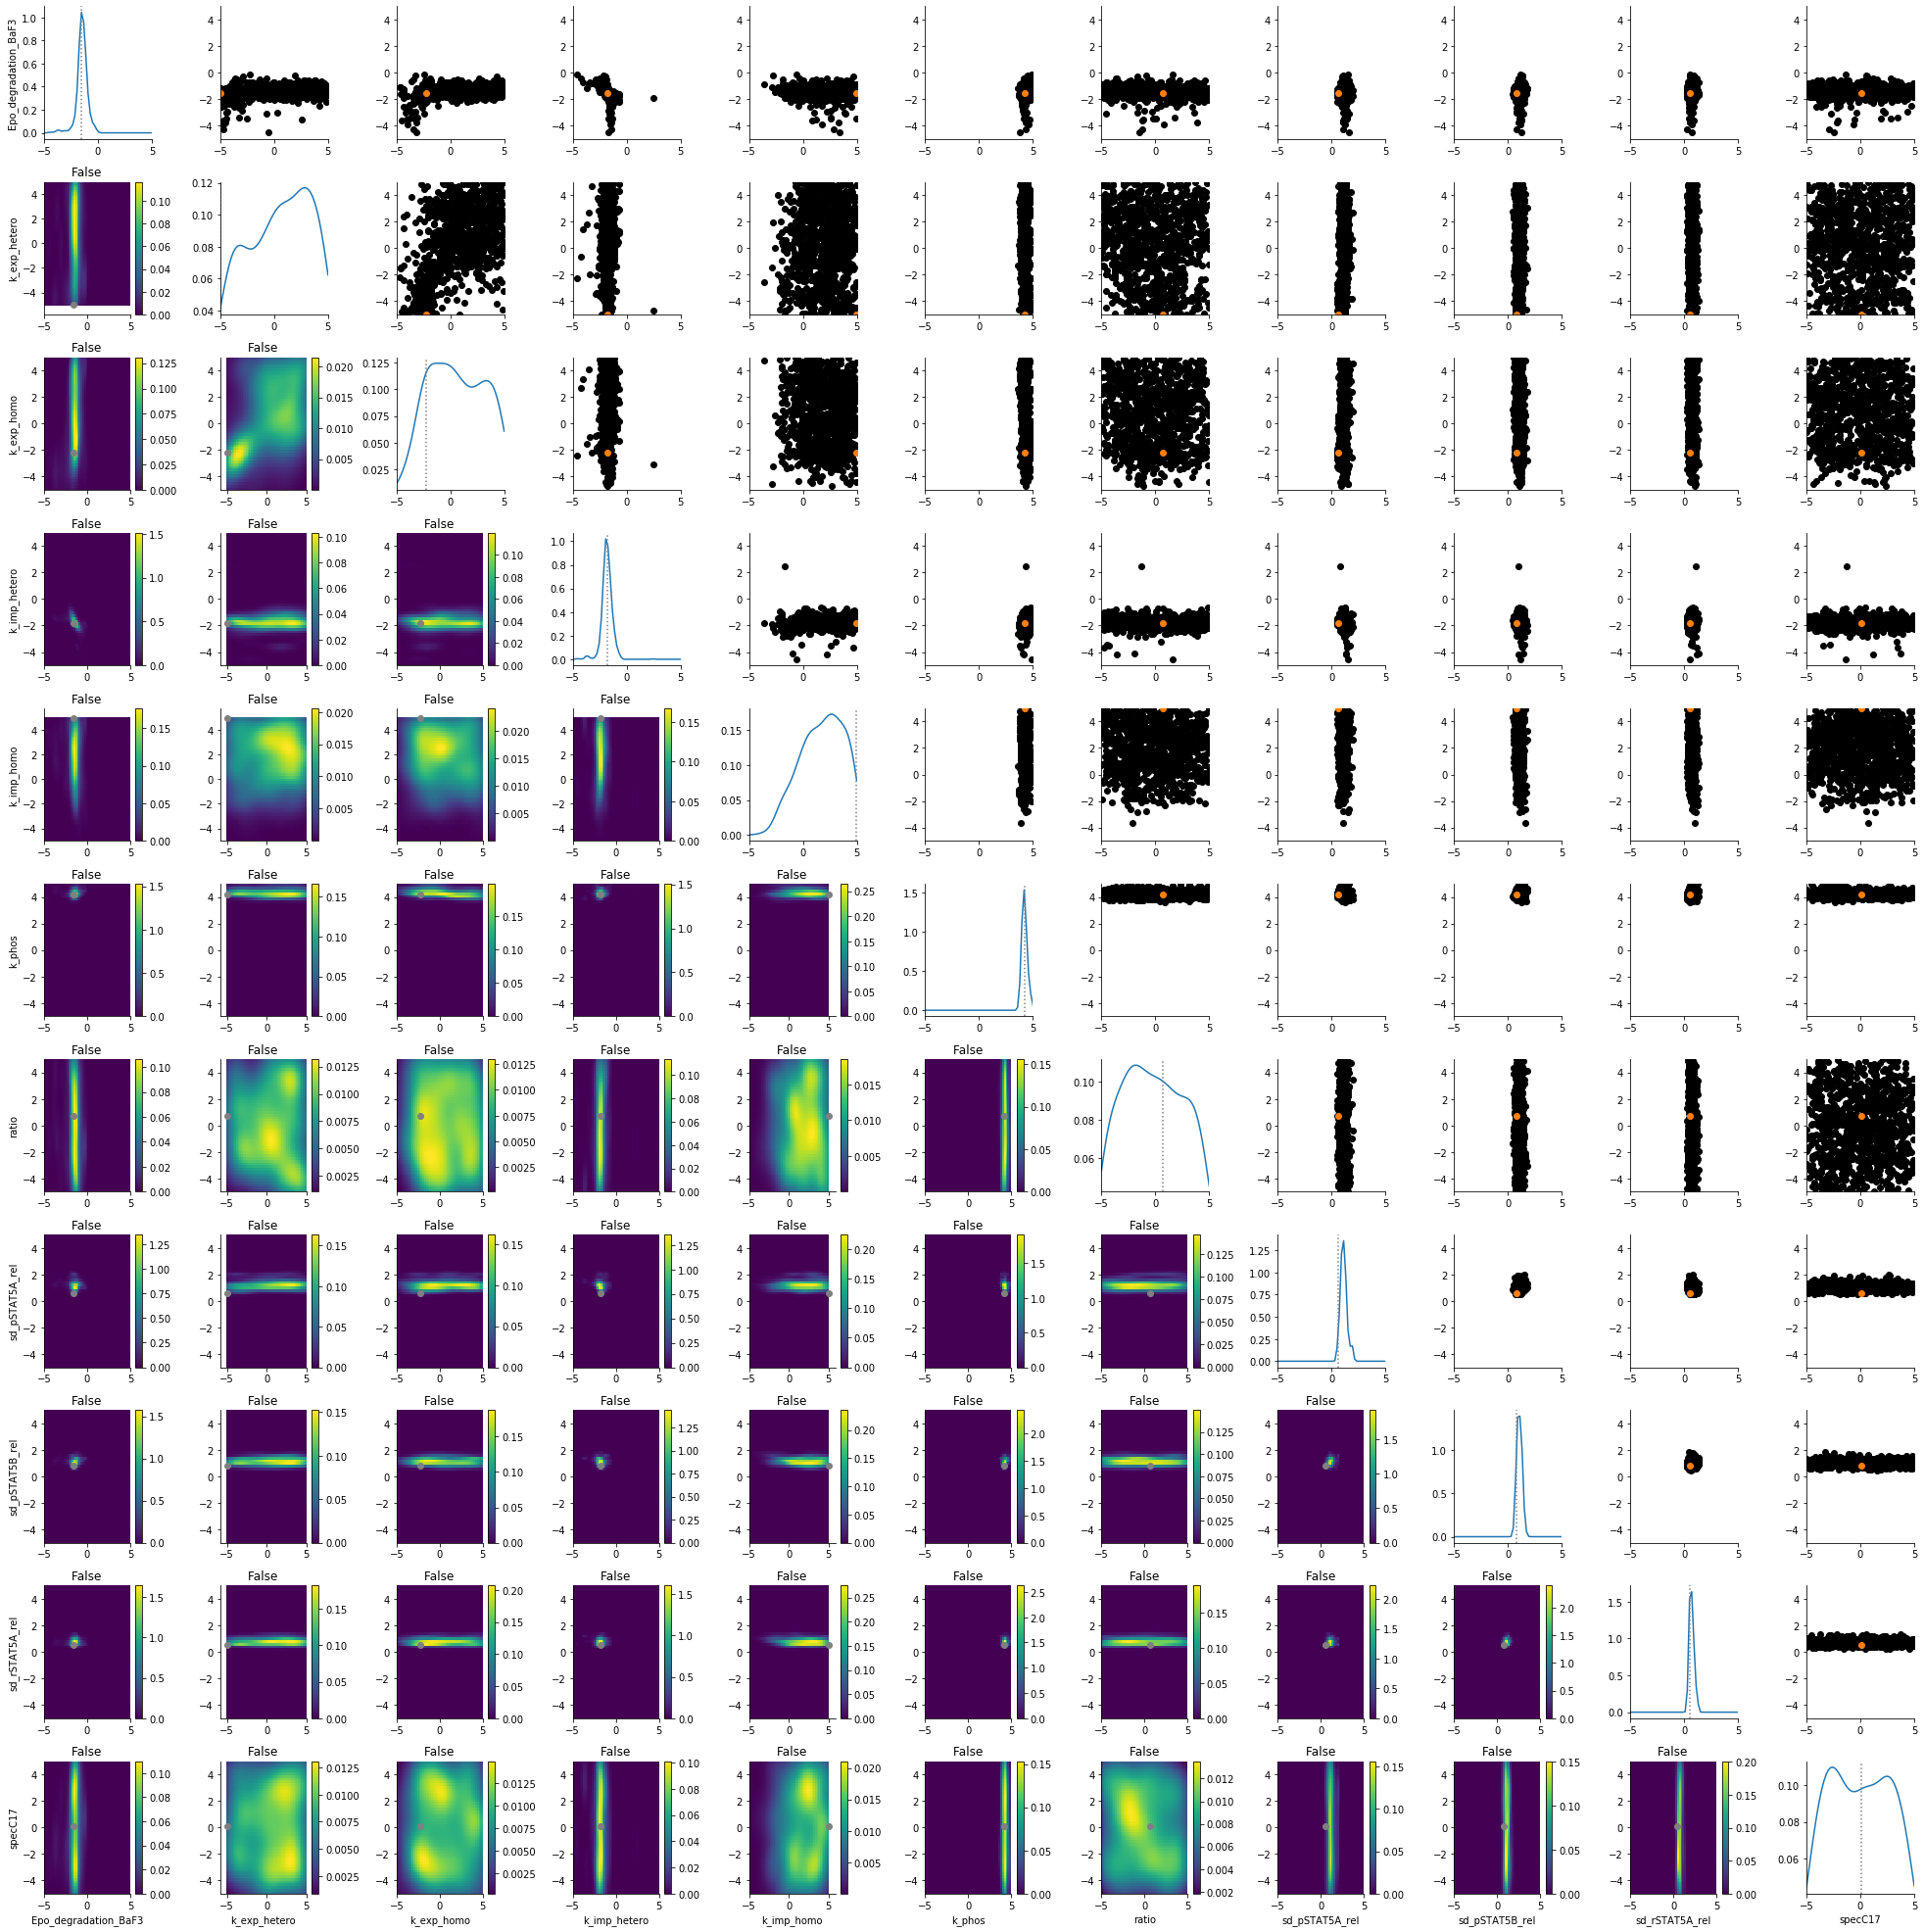

In [4]:
import pyabc
h = pyabc.History("sqlite:///h_boehm.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)

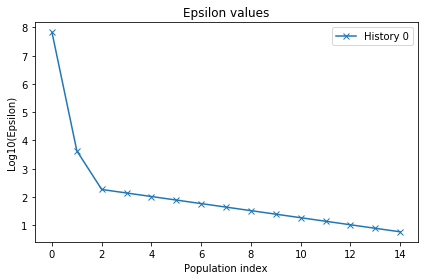

In [9]:
pyabc.visualization.plot_epsilons(h, scale="log10")

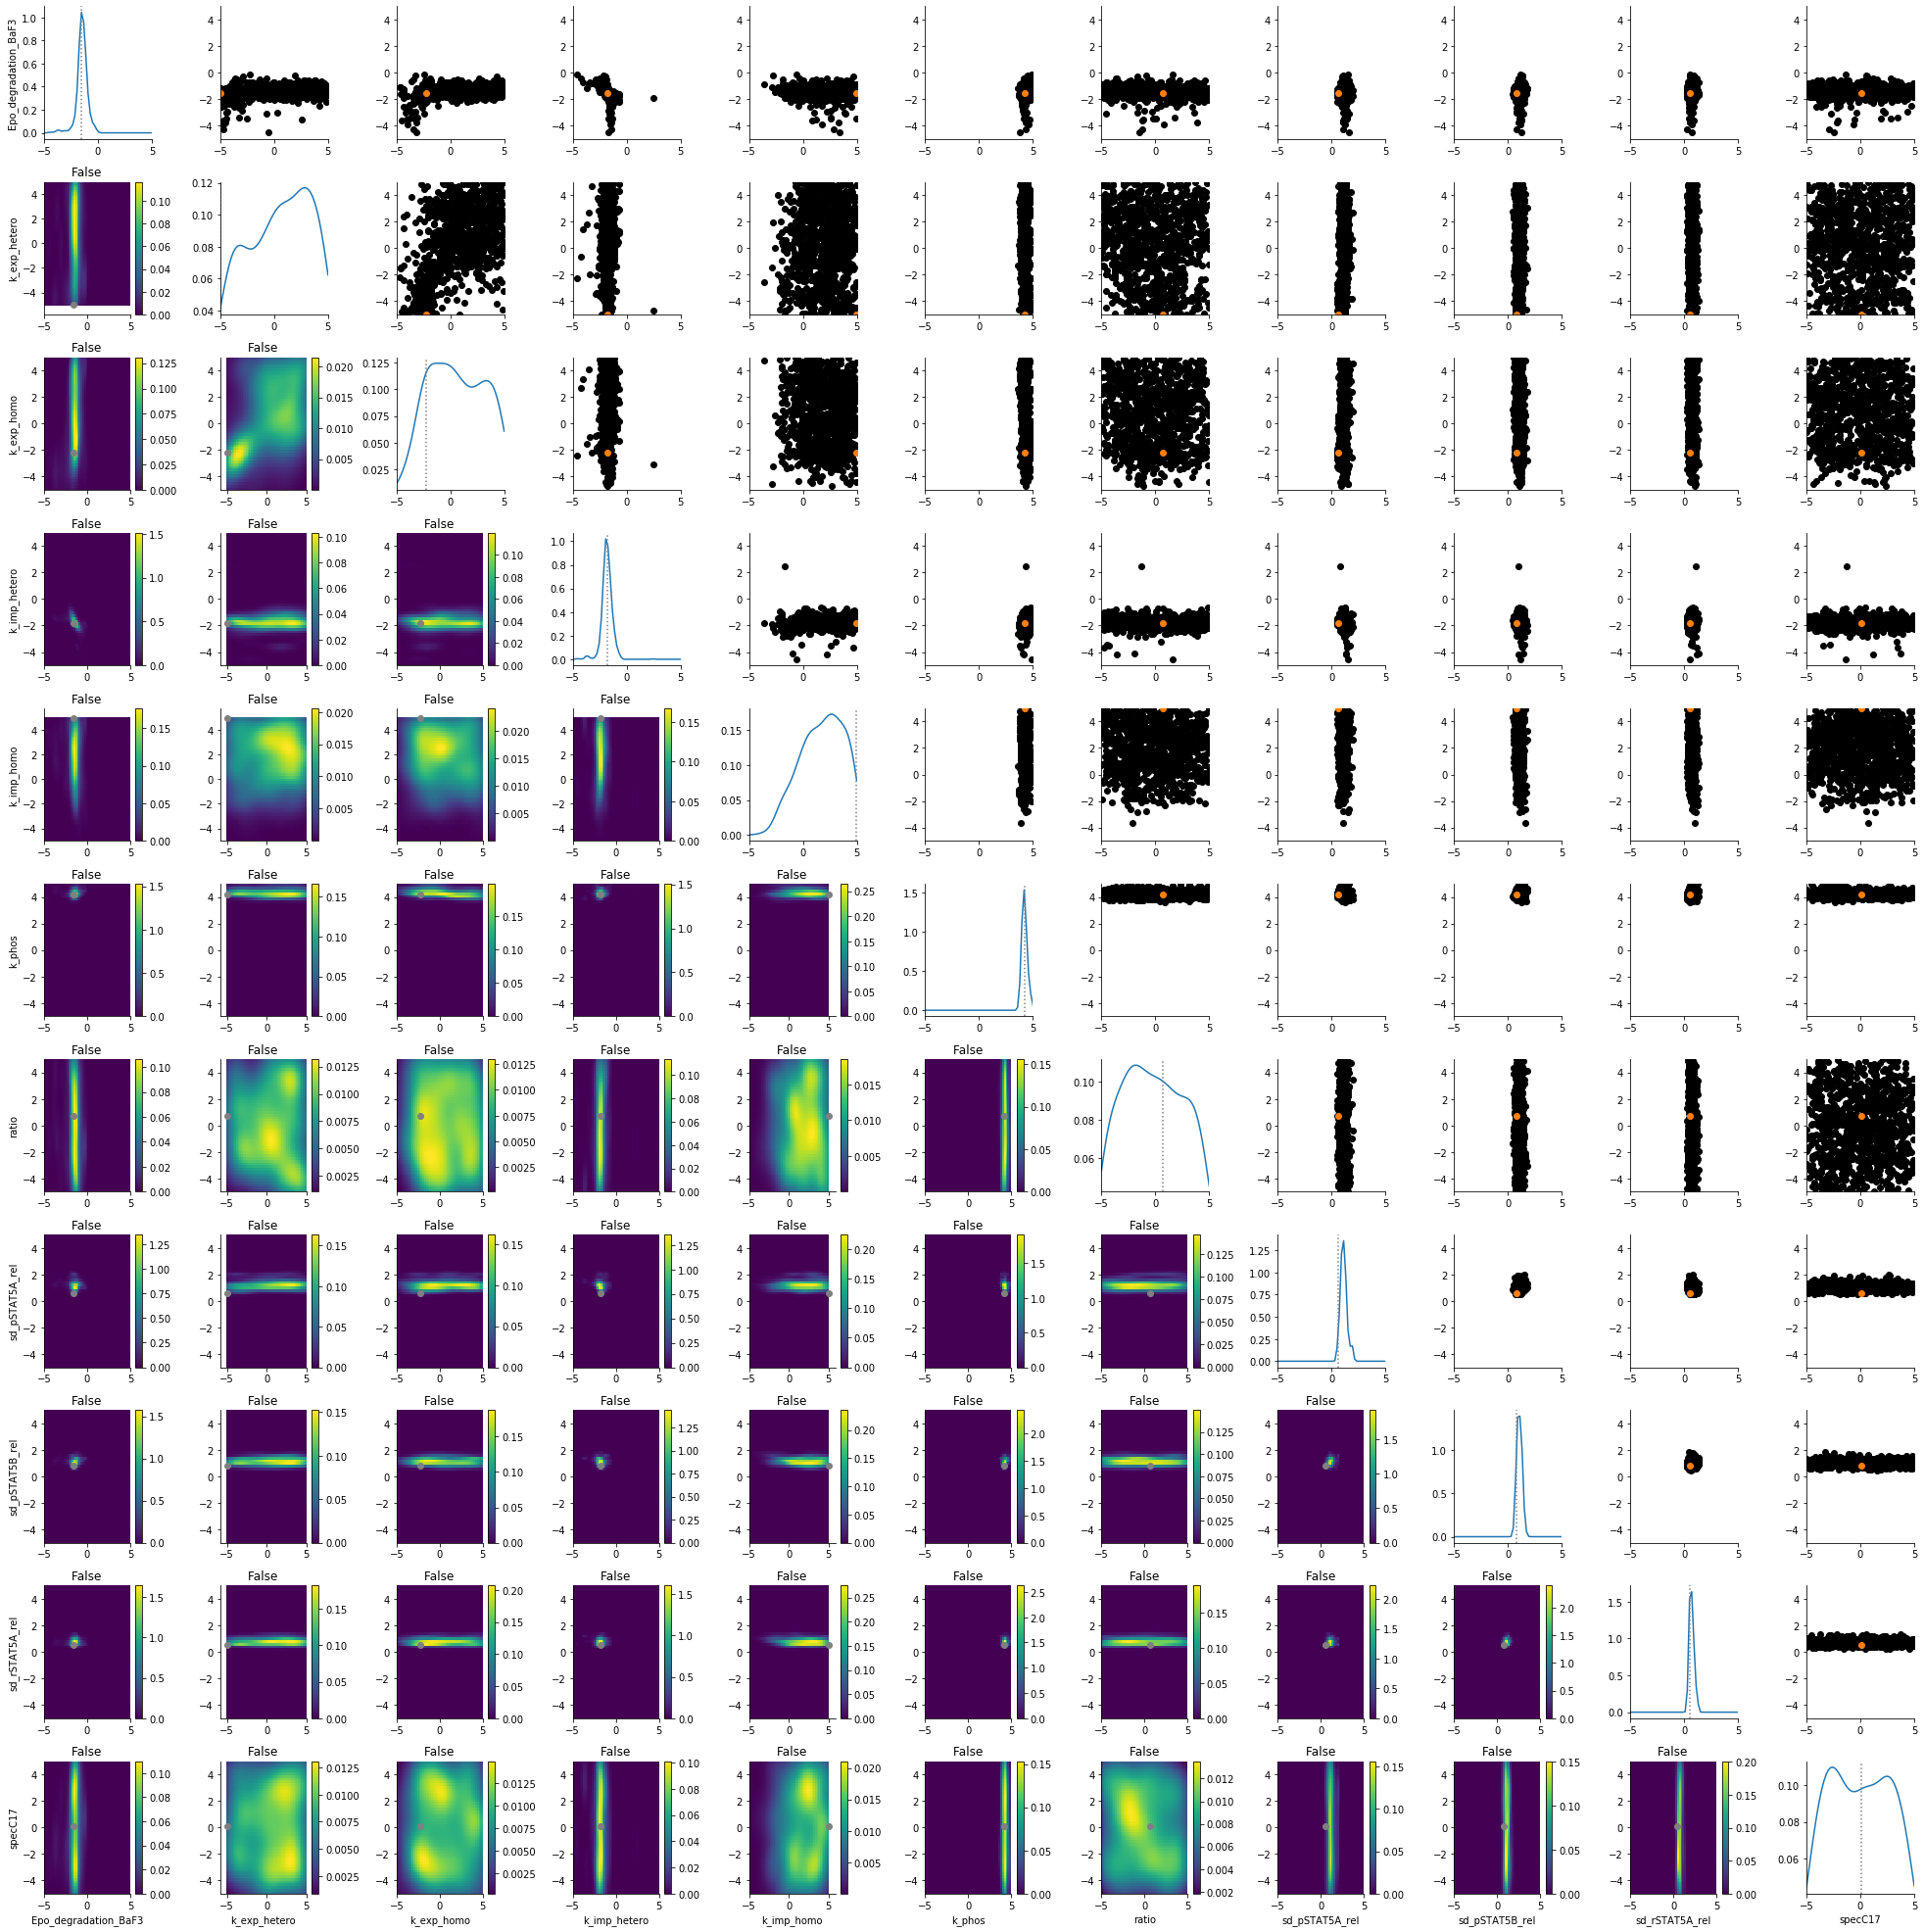

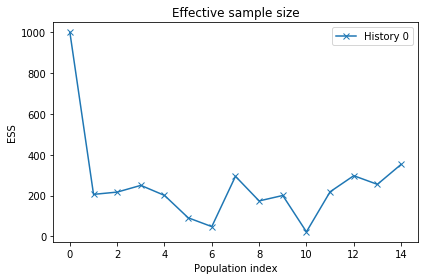

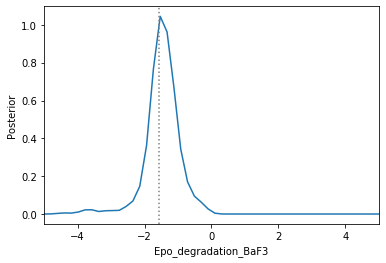

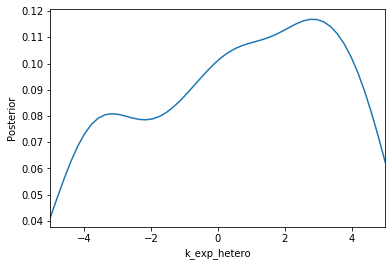

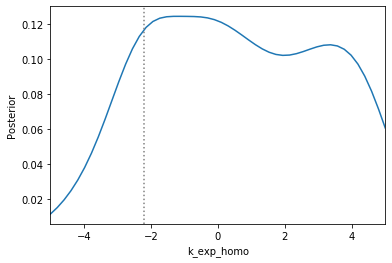

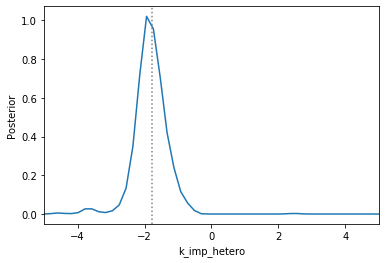

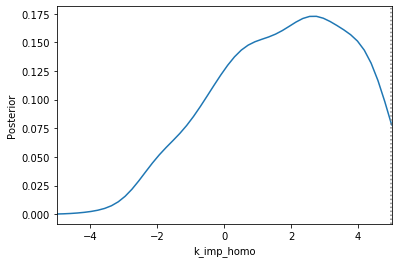

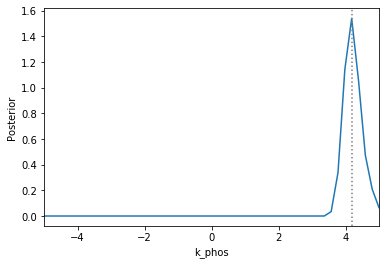

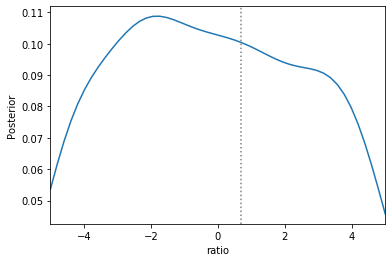

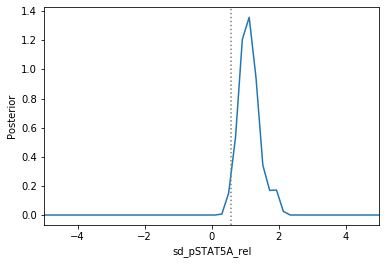

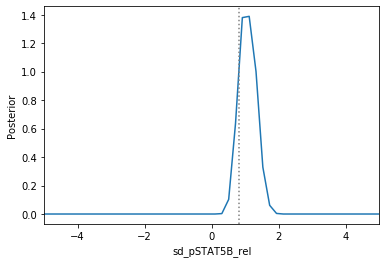

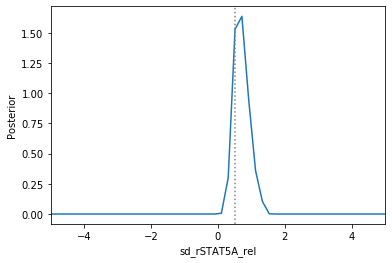

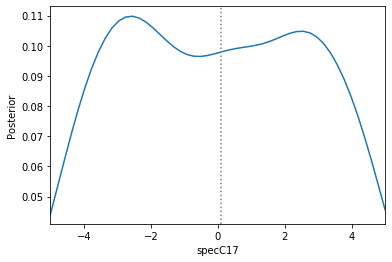

In [6]:
h = pyabc.History("sqlite:///h_boehm.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)

pyabc.visualization.plot_effective_sample_sizes(h)

for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

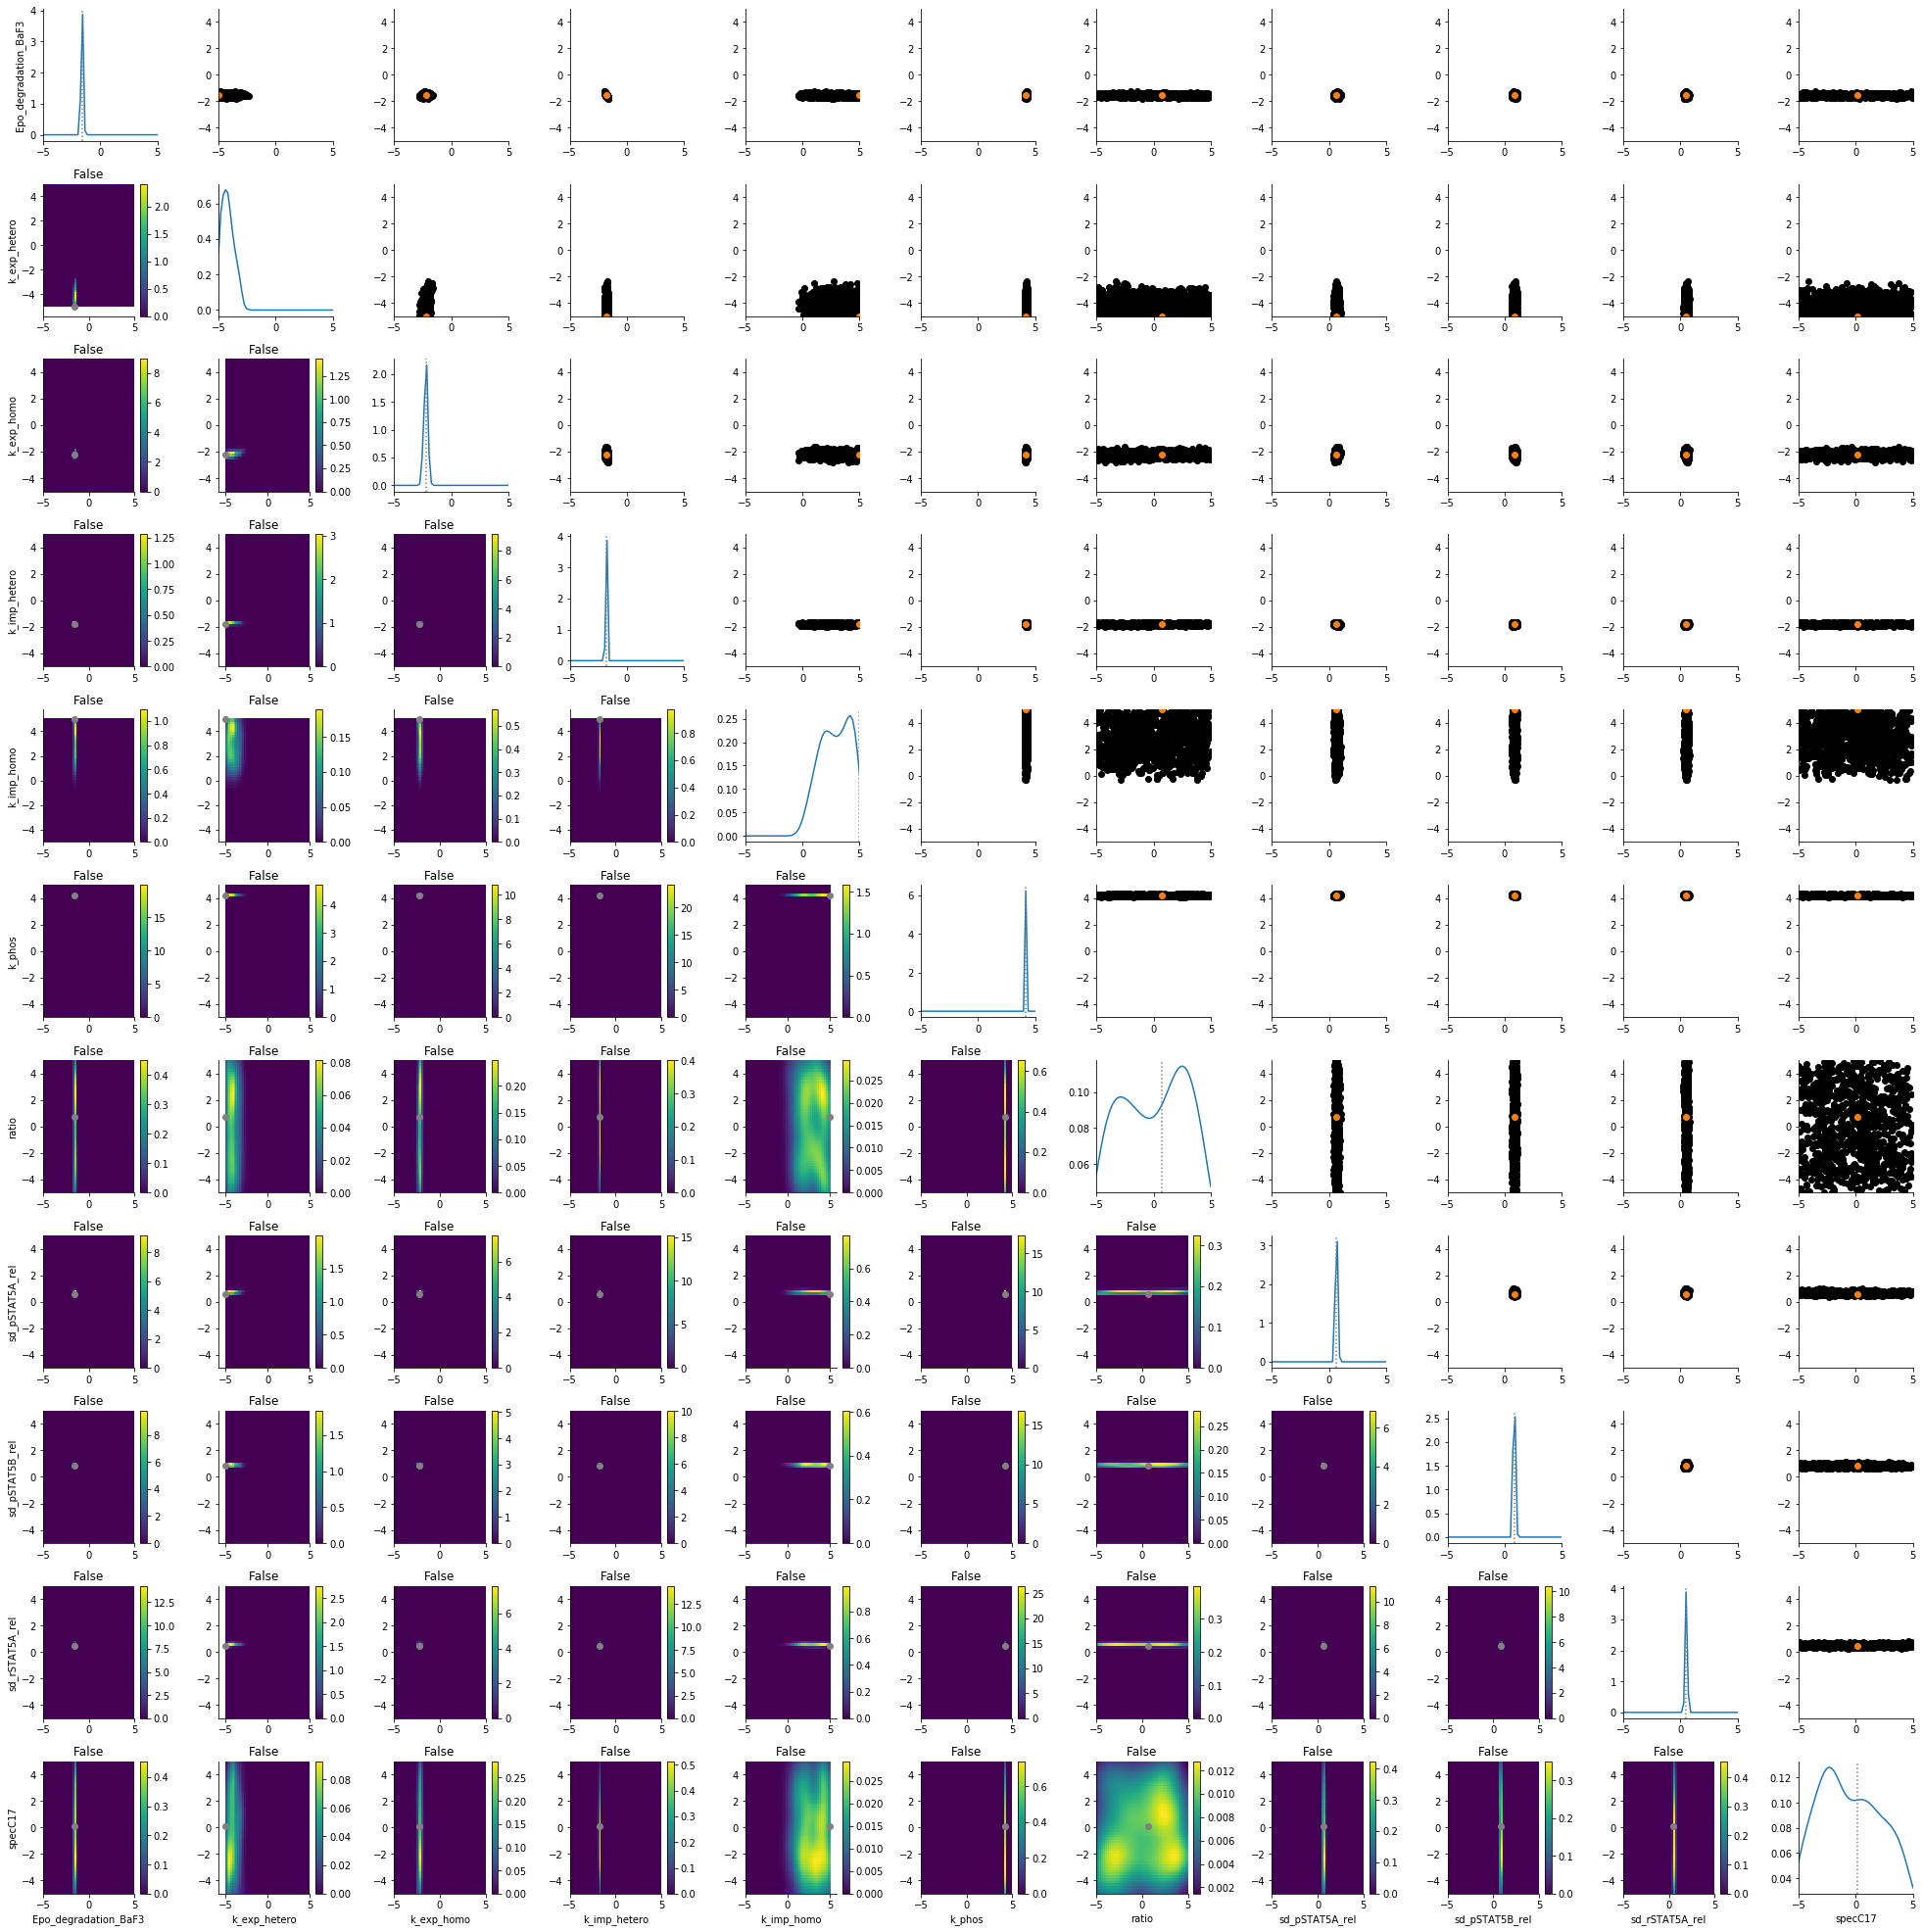

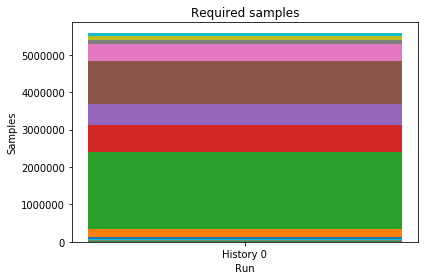

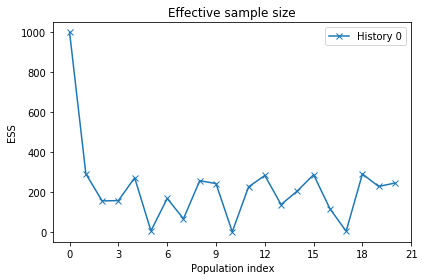

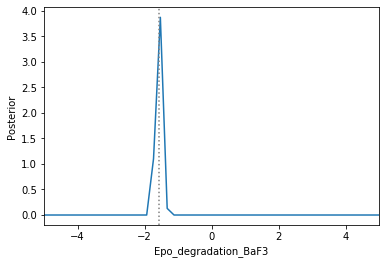

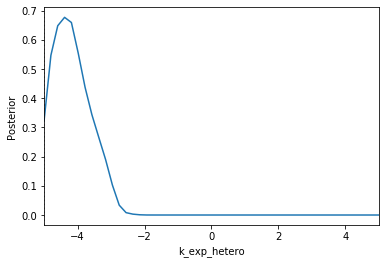

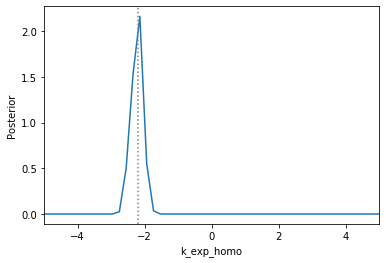

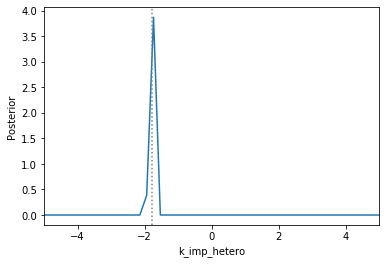

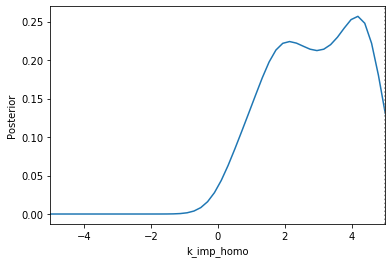

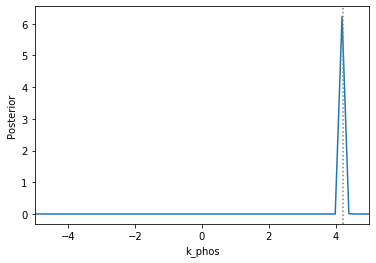

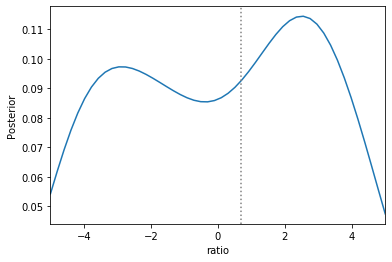

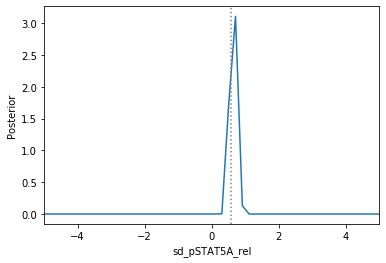

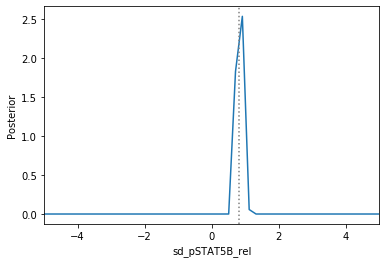

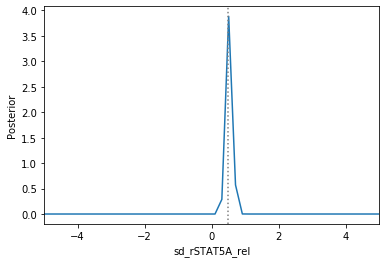

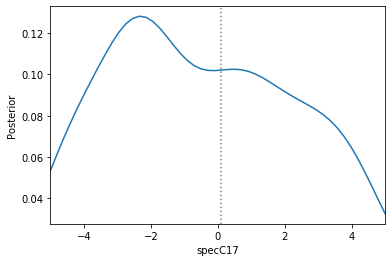

In [6]:
h = pyabc.History("sqlite:///h_boehm2.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)
pyabc.visualization.plot_sample_numbers(h)

pyabc.visualization.plot_effective_sample_sizes(h)
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

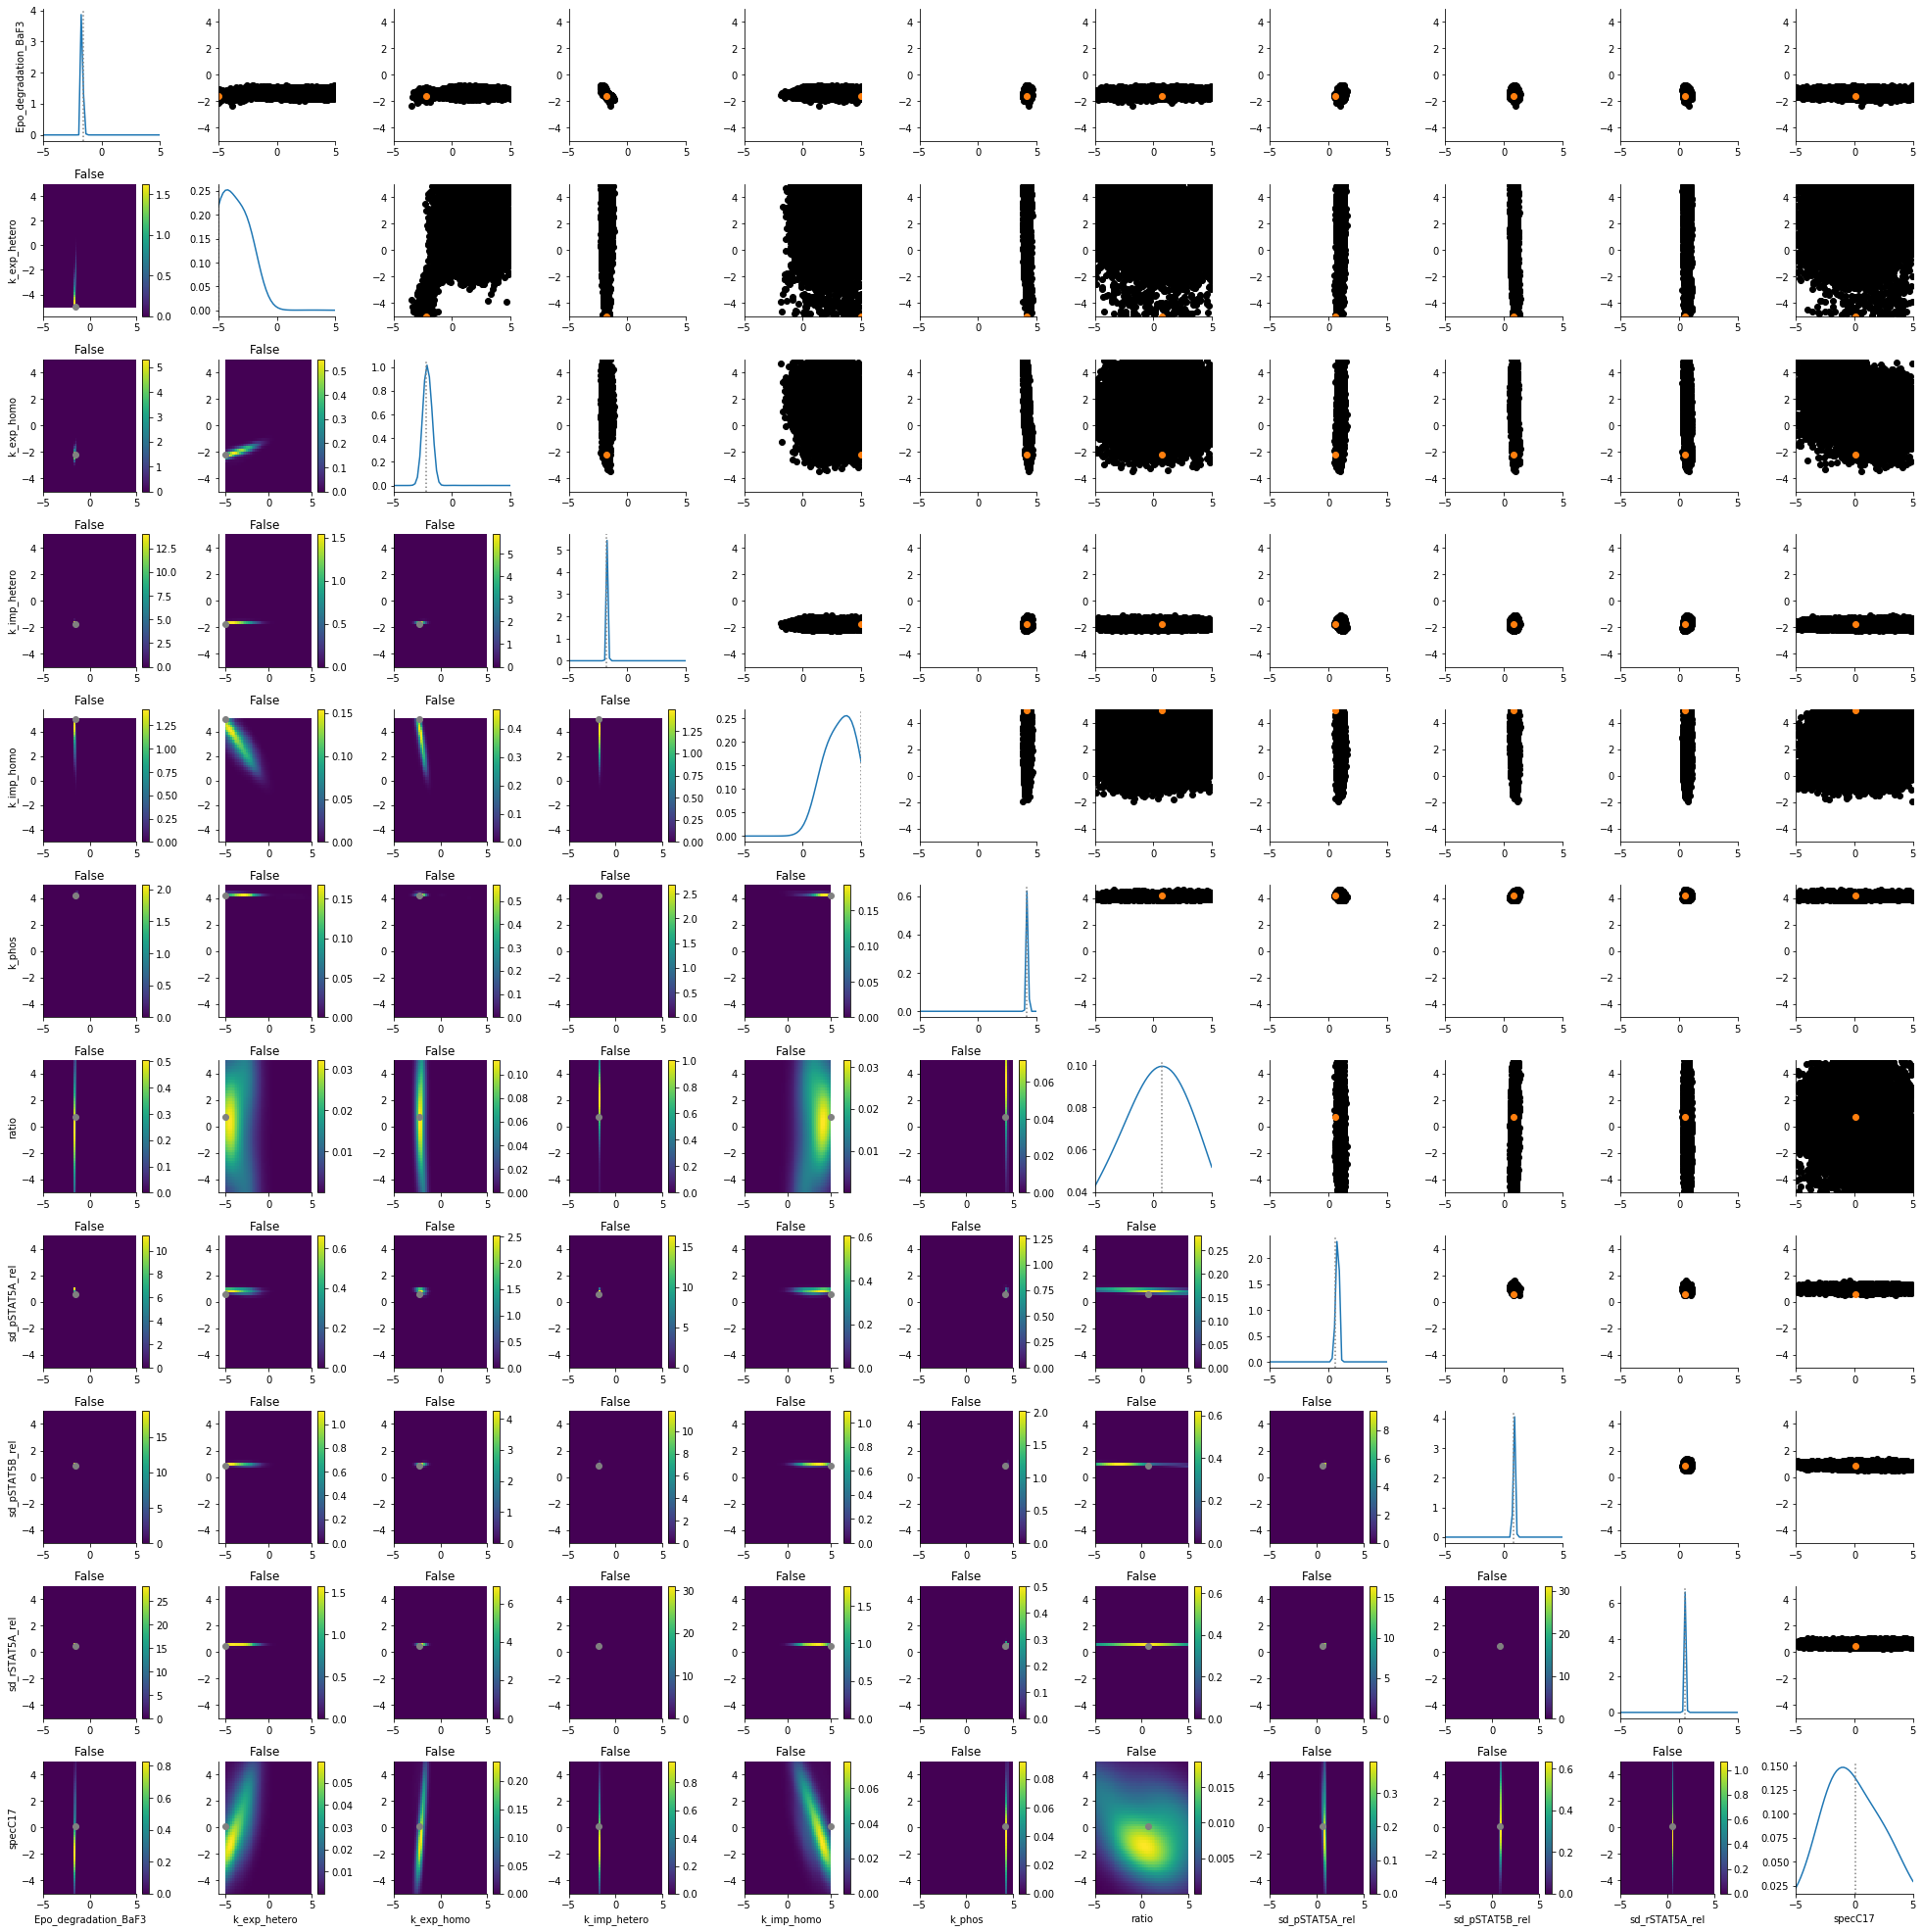

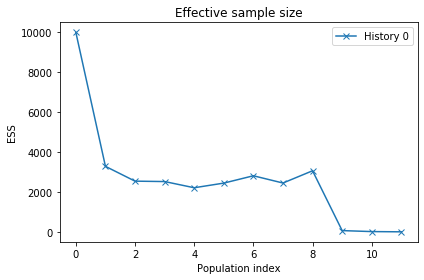

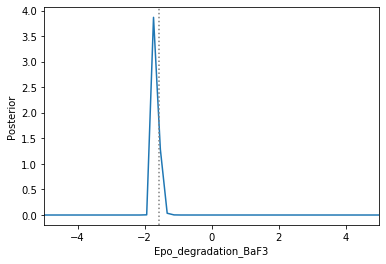

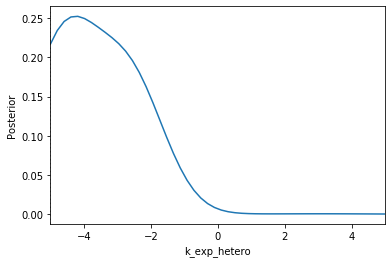

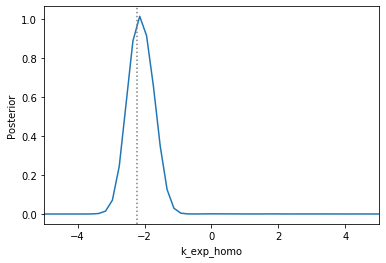

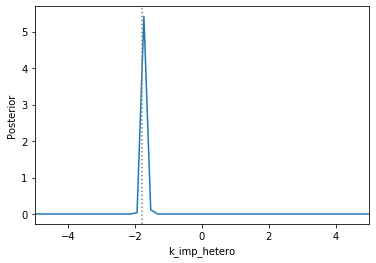

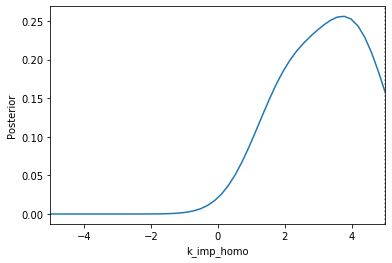

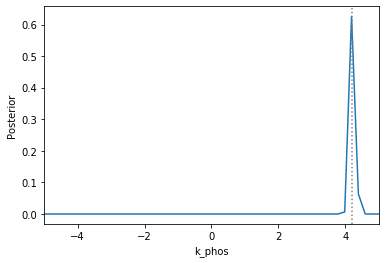

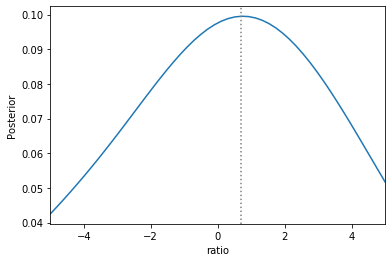

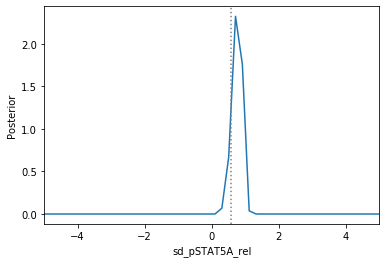

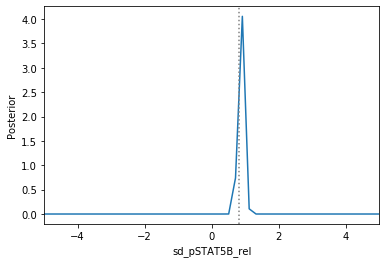

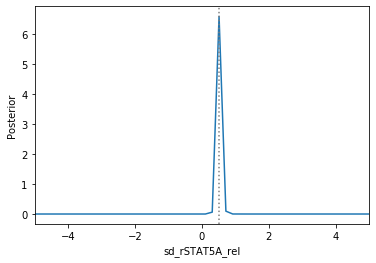

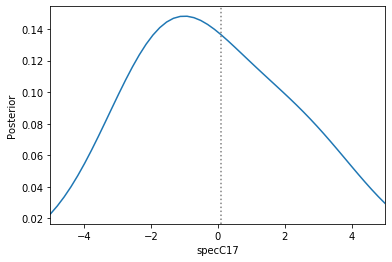

In [3]:
h = pyabc.History("sqlite:///h_boehm3.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)

pyabc.visualization.plot_effective_sample_sizes(h)
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

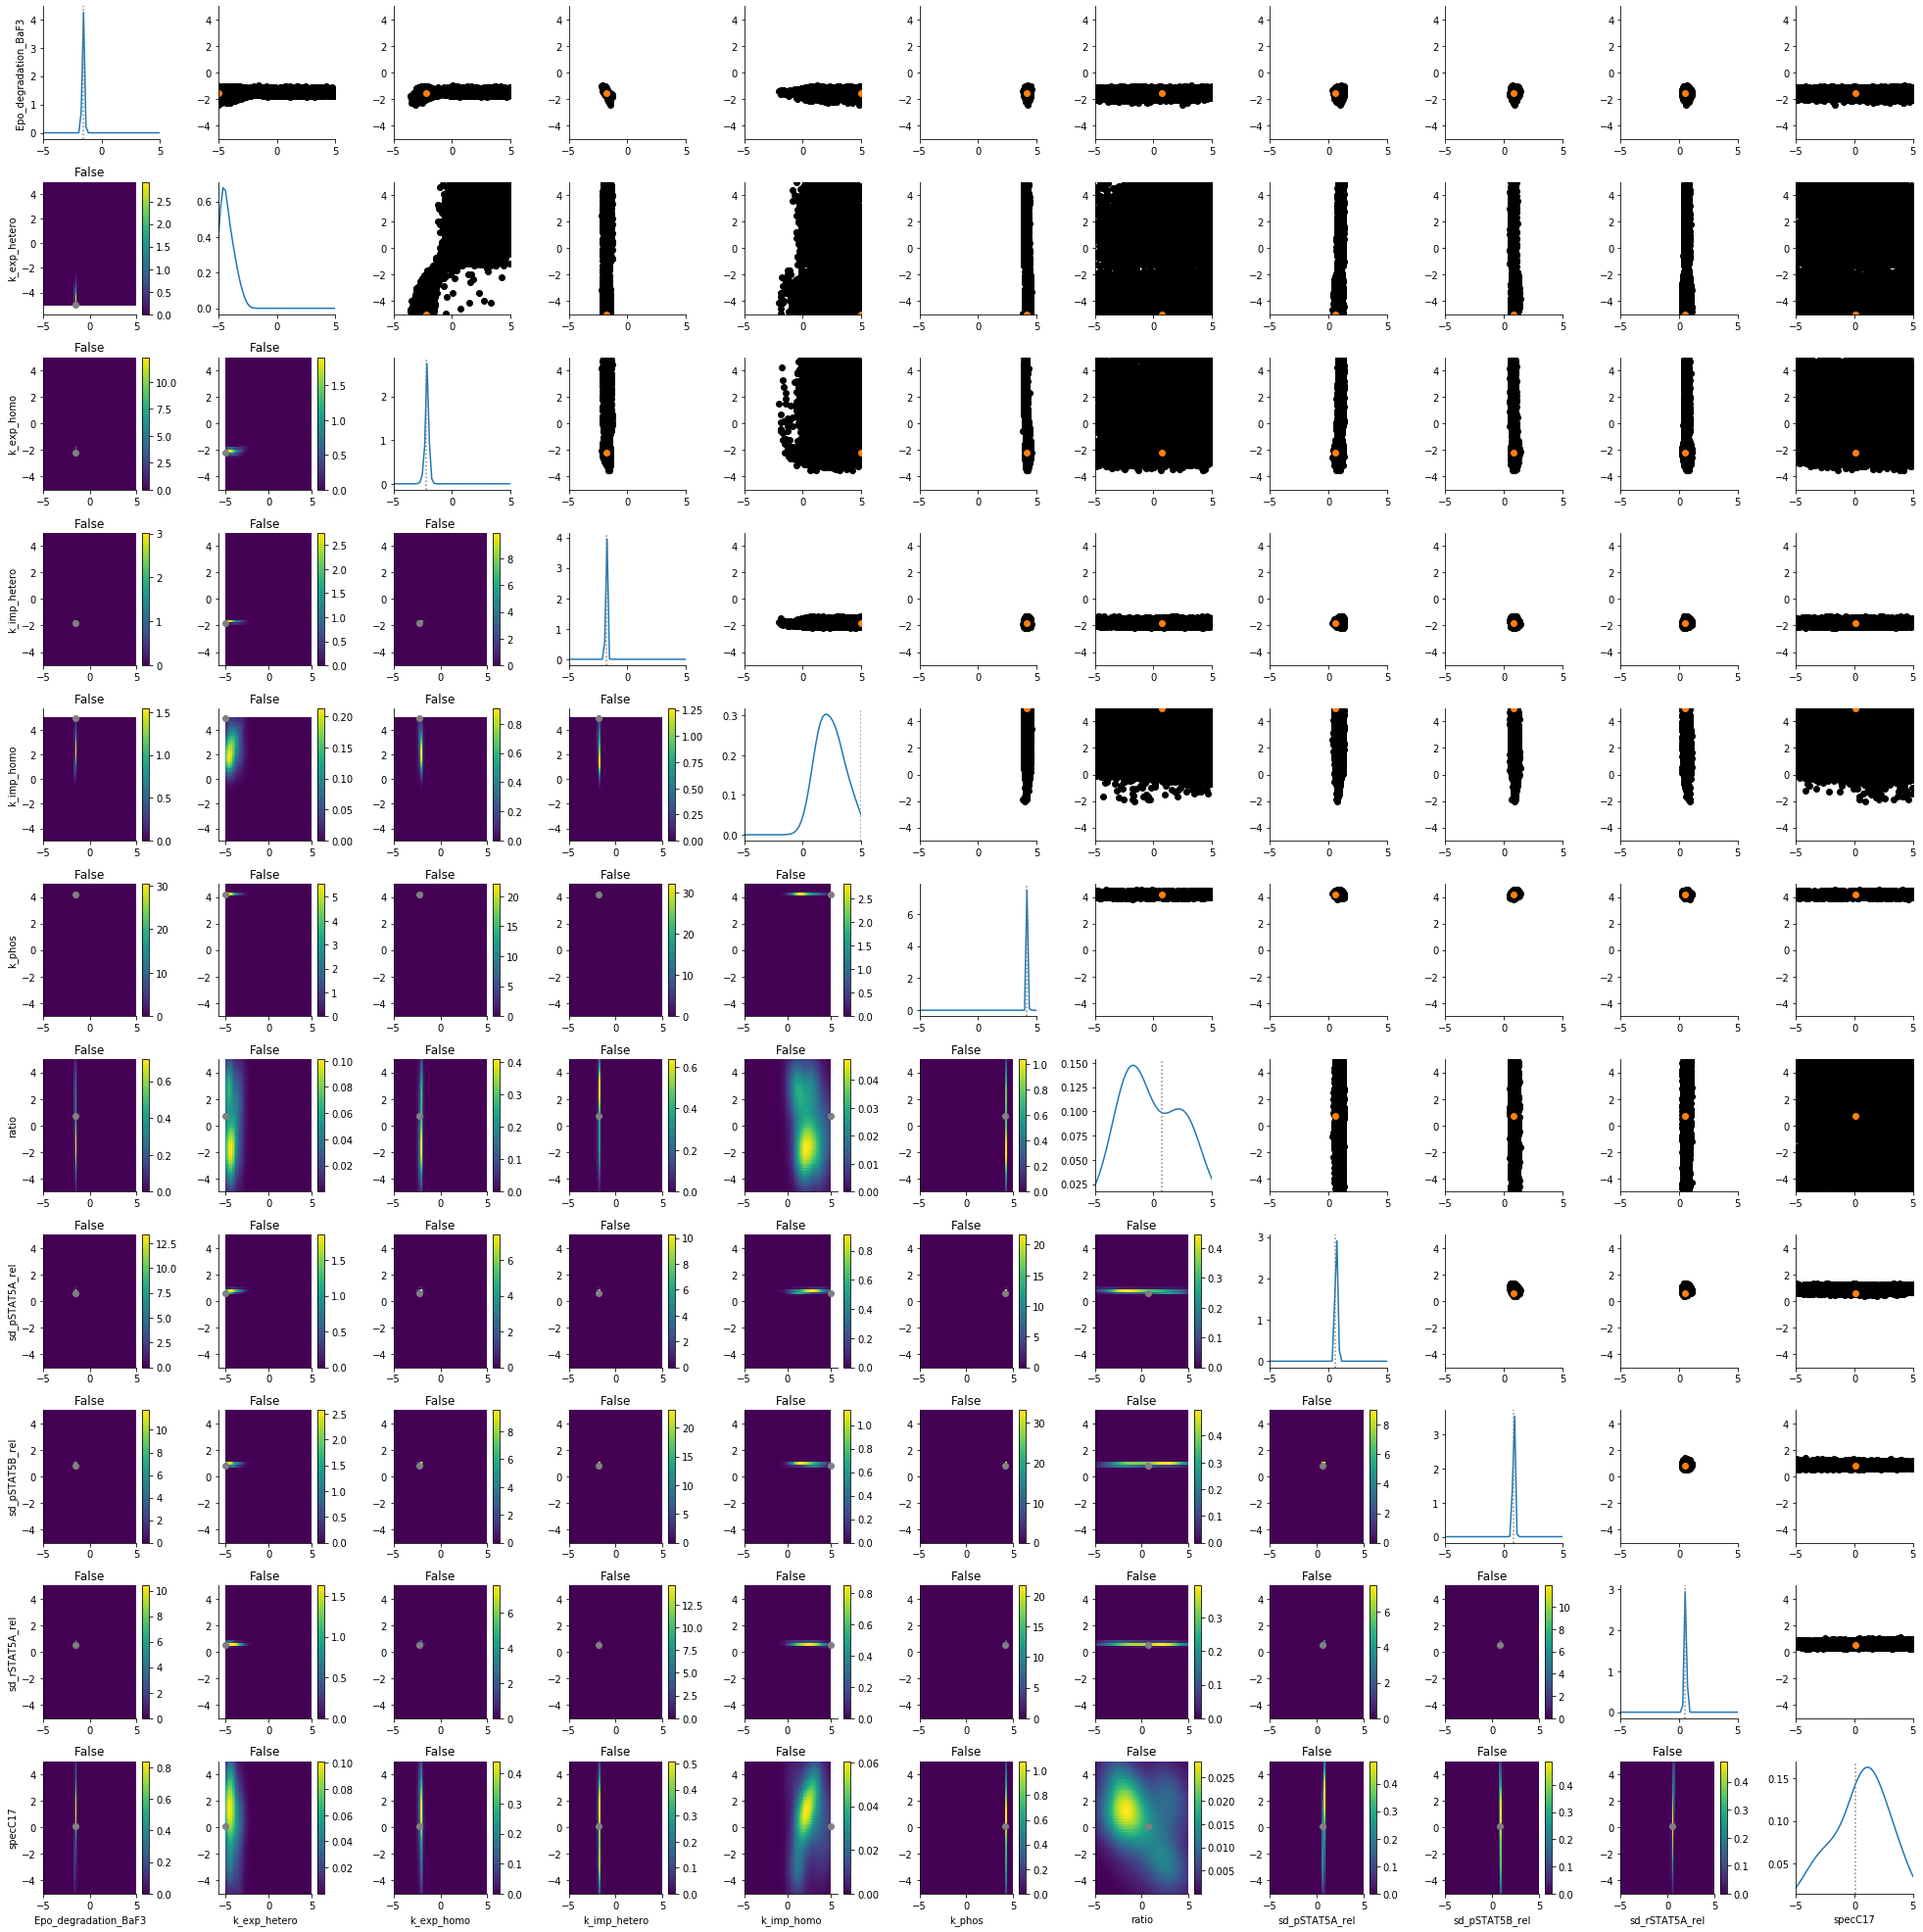

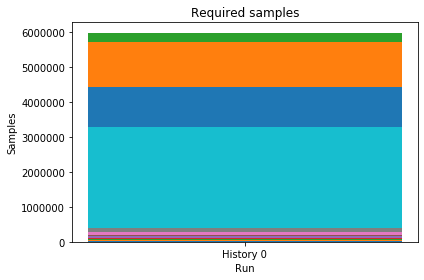

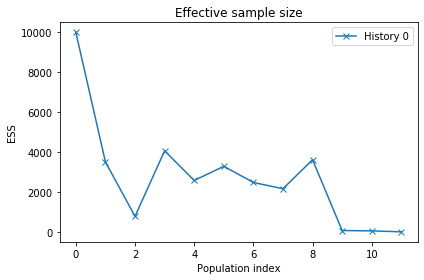

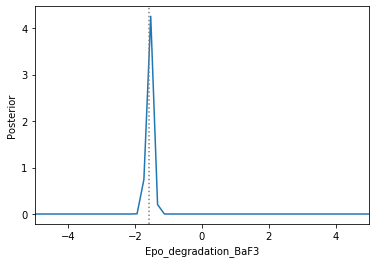

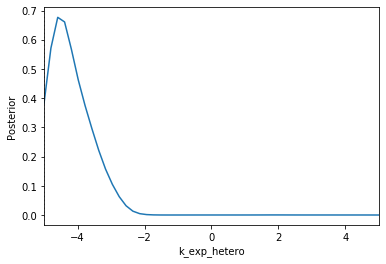

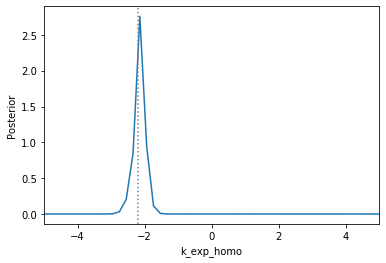

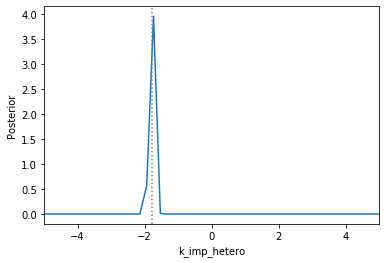

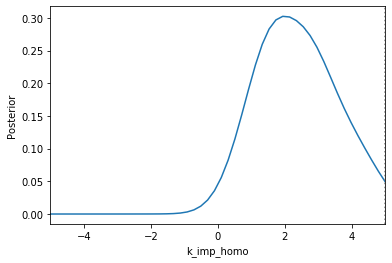

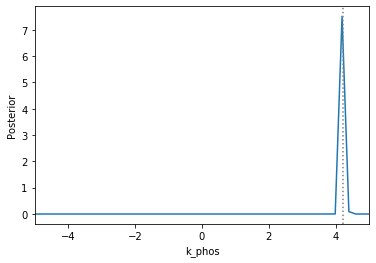

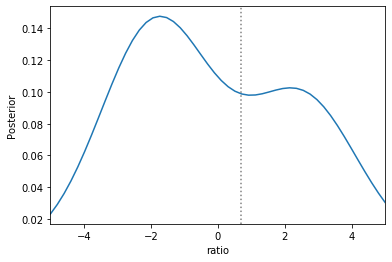

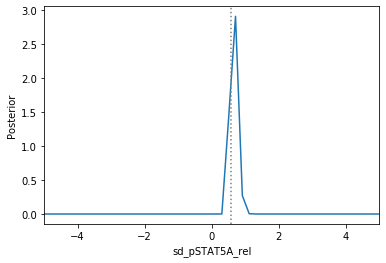

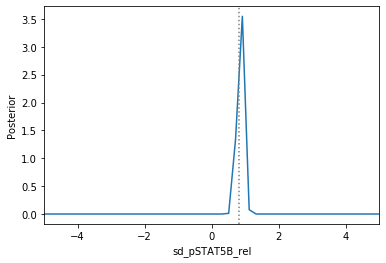

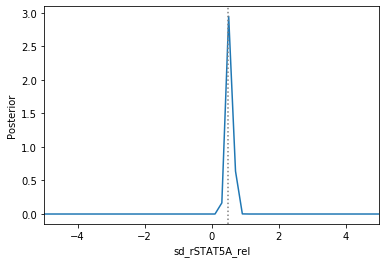

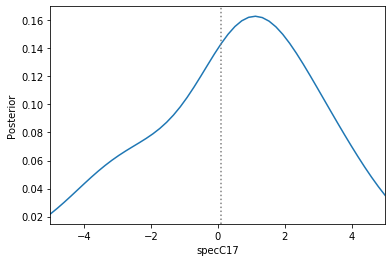

In [4]:
h = pyabc.History("sqlite:///h_boehm4.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)
pyabc.visualization.plot_sample_numbers(h)
pyabc.visualization.plot_effective_sample_sizes(h)
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

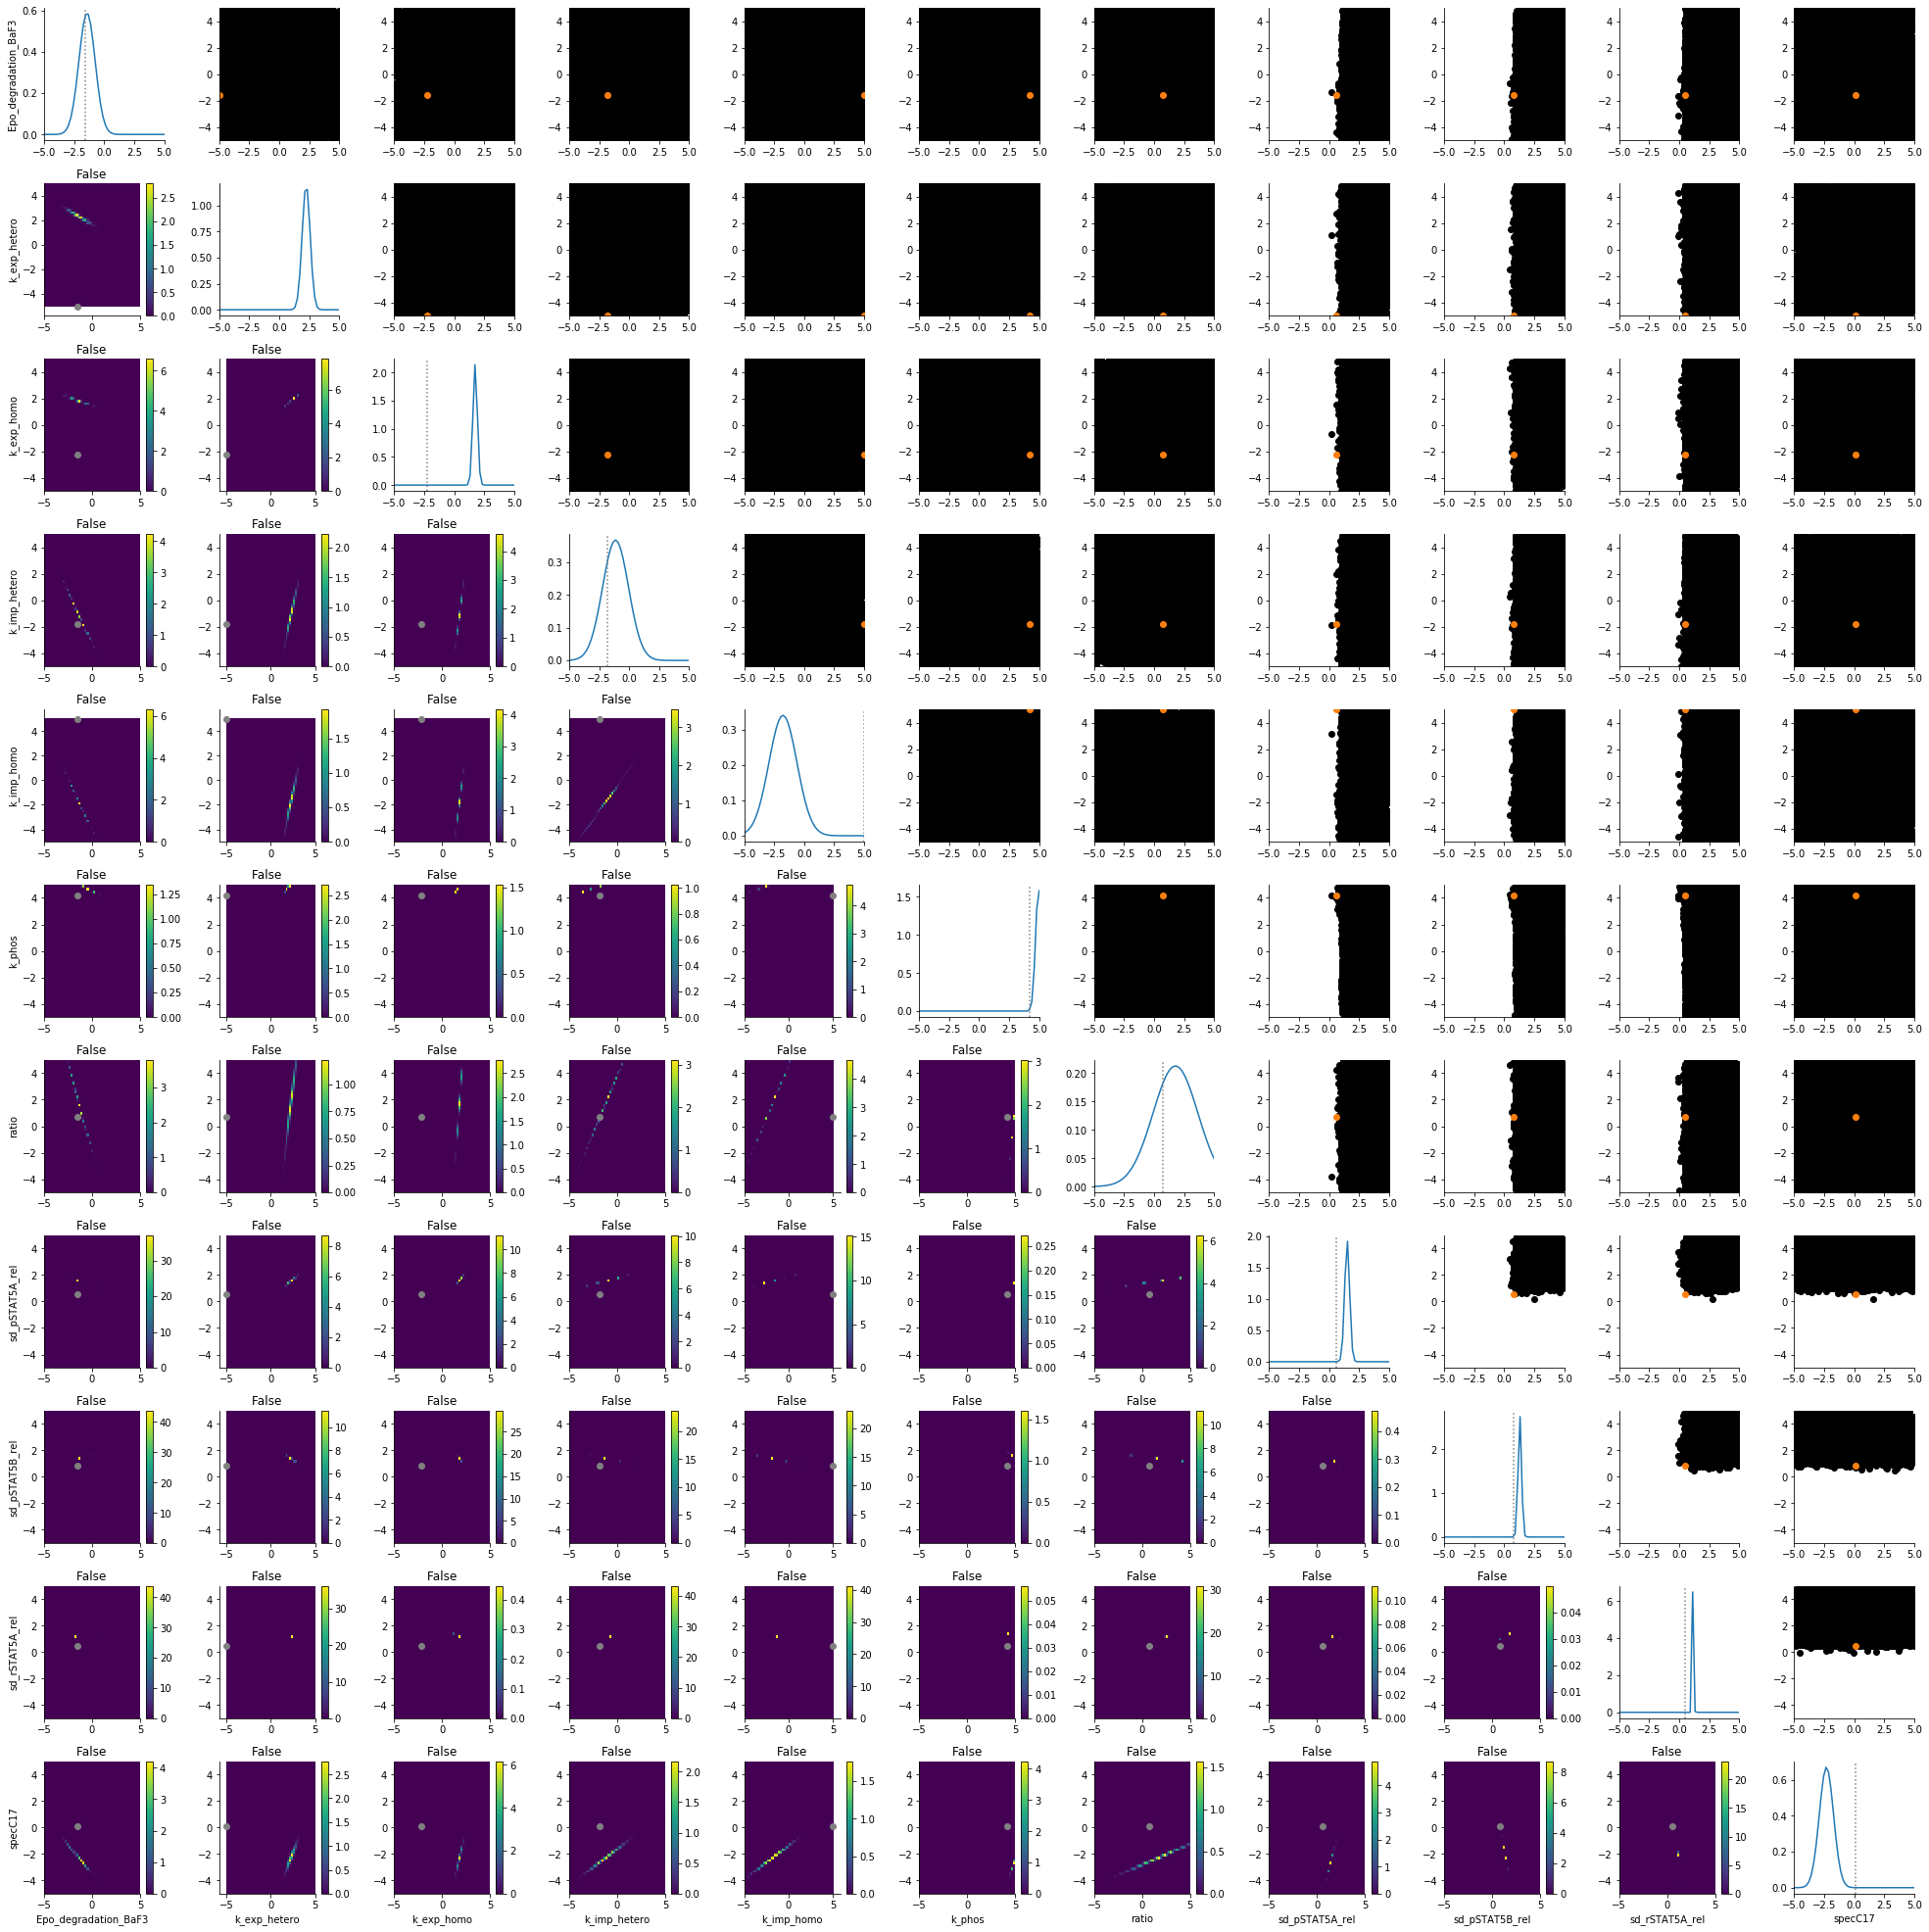

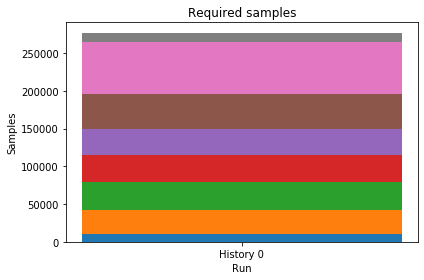

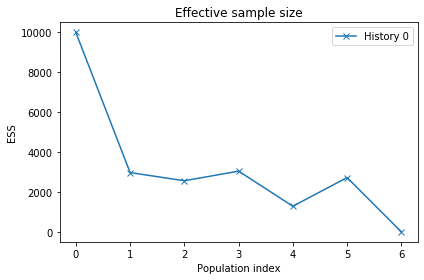

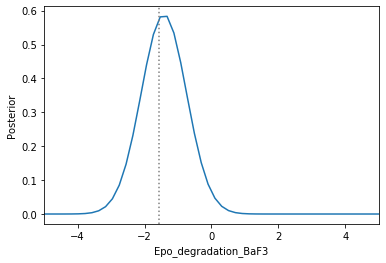

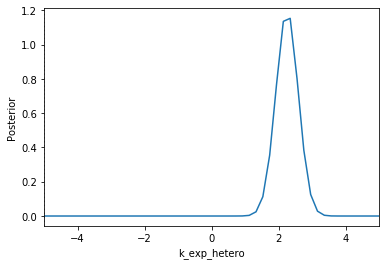

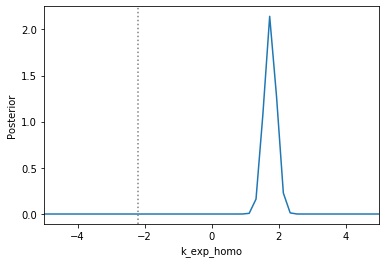

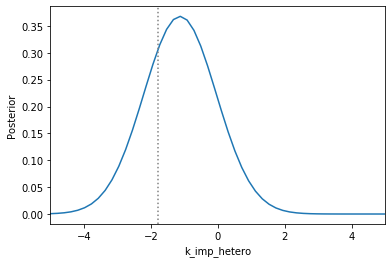

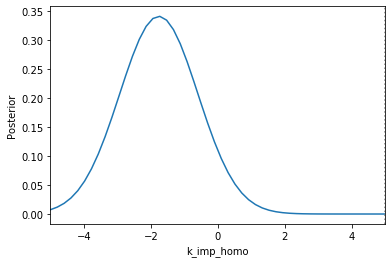

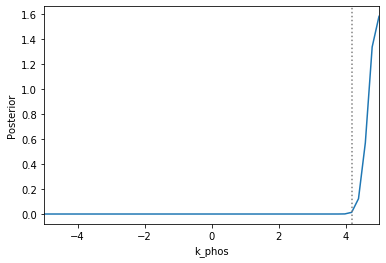

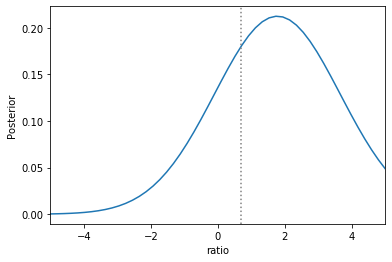

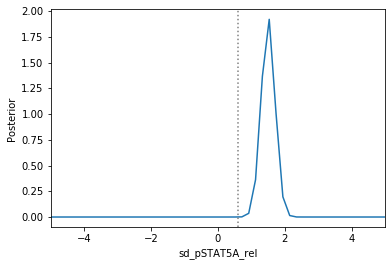

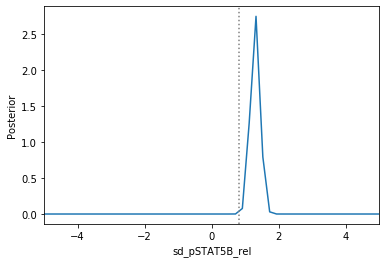

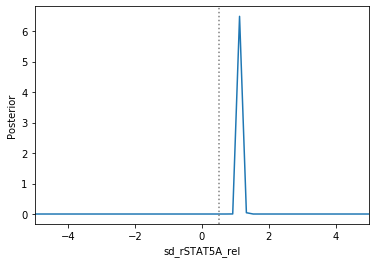

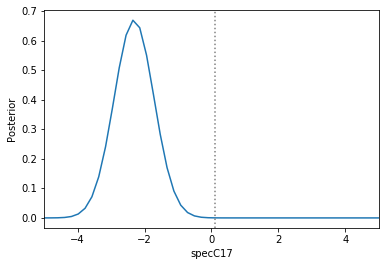

In [5]:
h = pyabc.History("sqlite:///h_boehm5.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)
pyabc.visualization.plot_sample_numbers(h)
pyabc.visualization.plot_effective_sample_sizes(h)
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

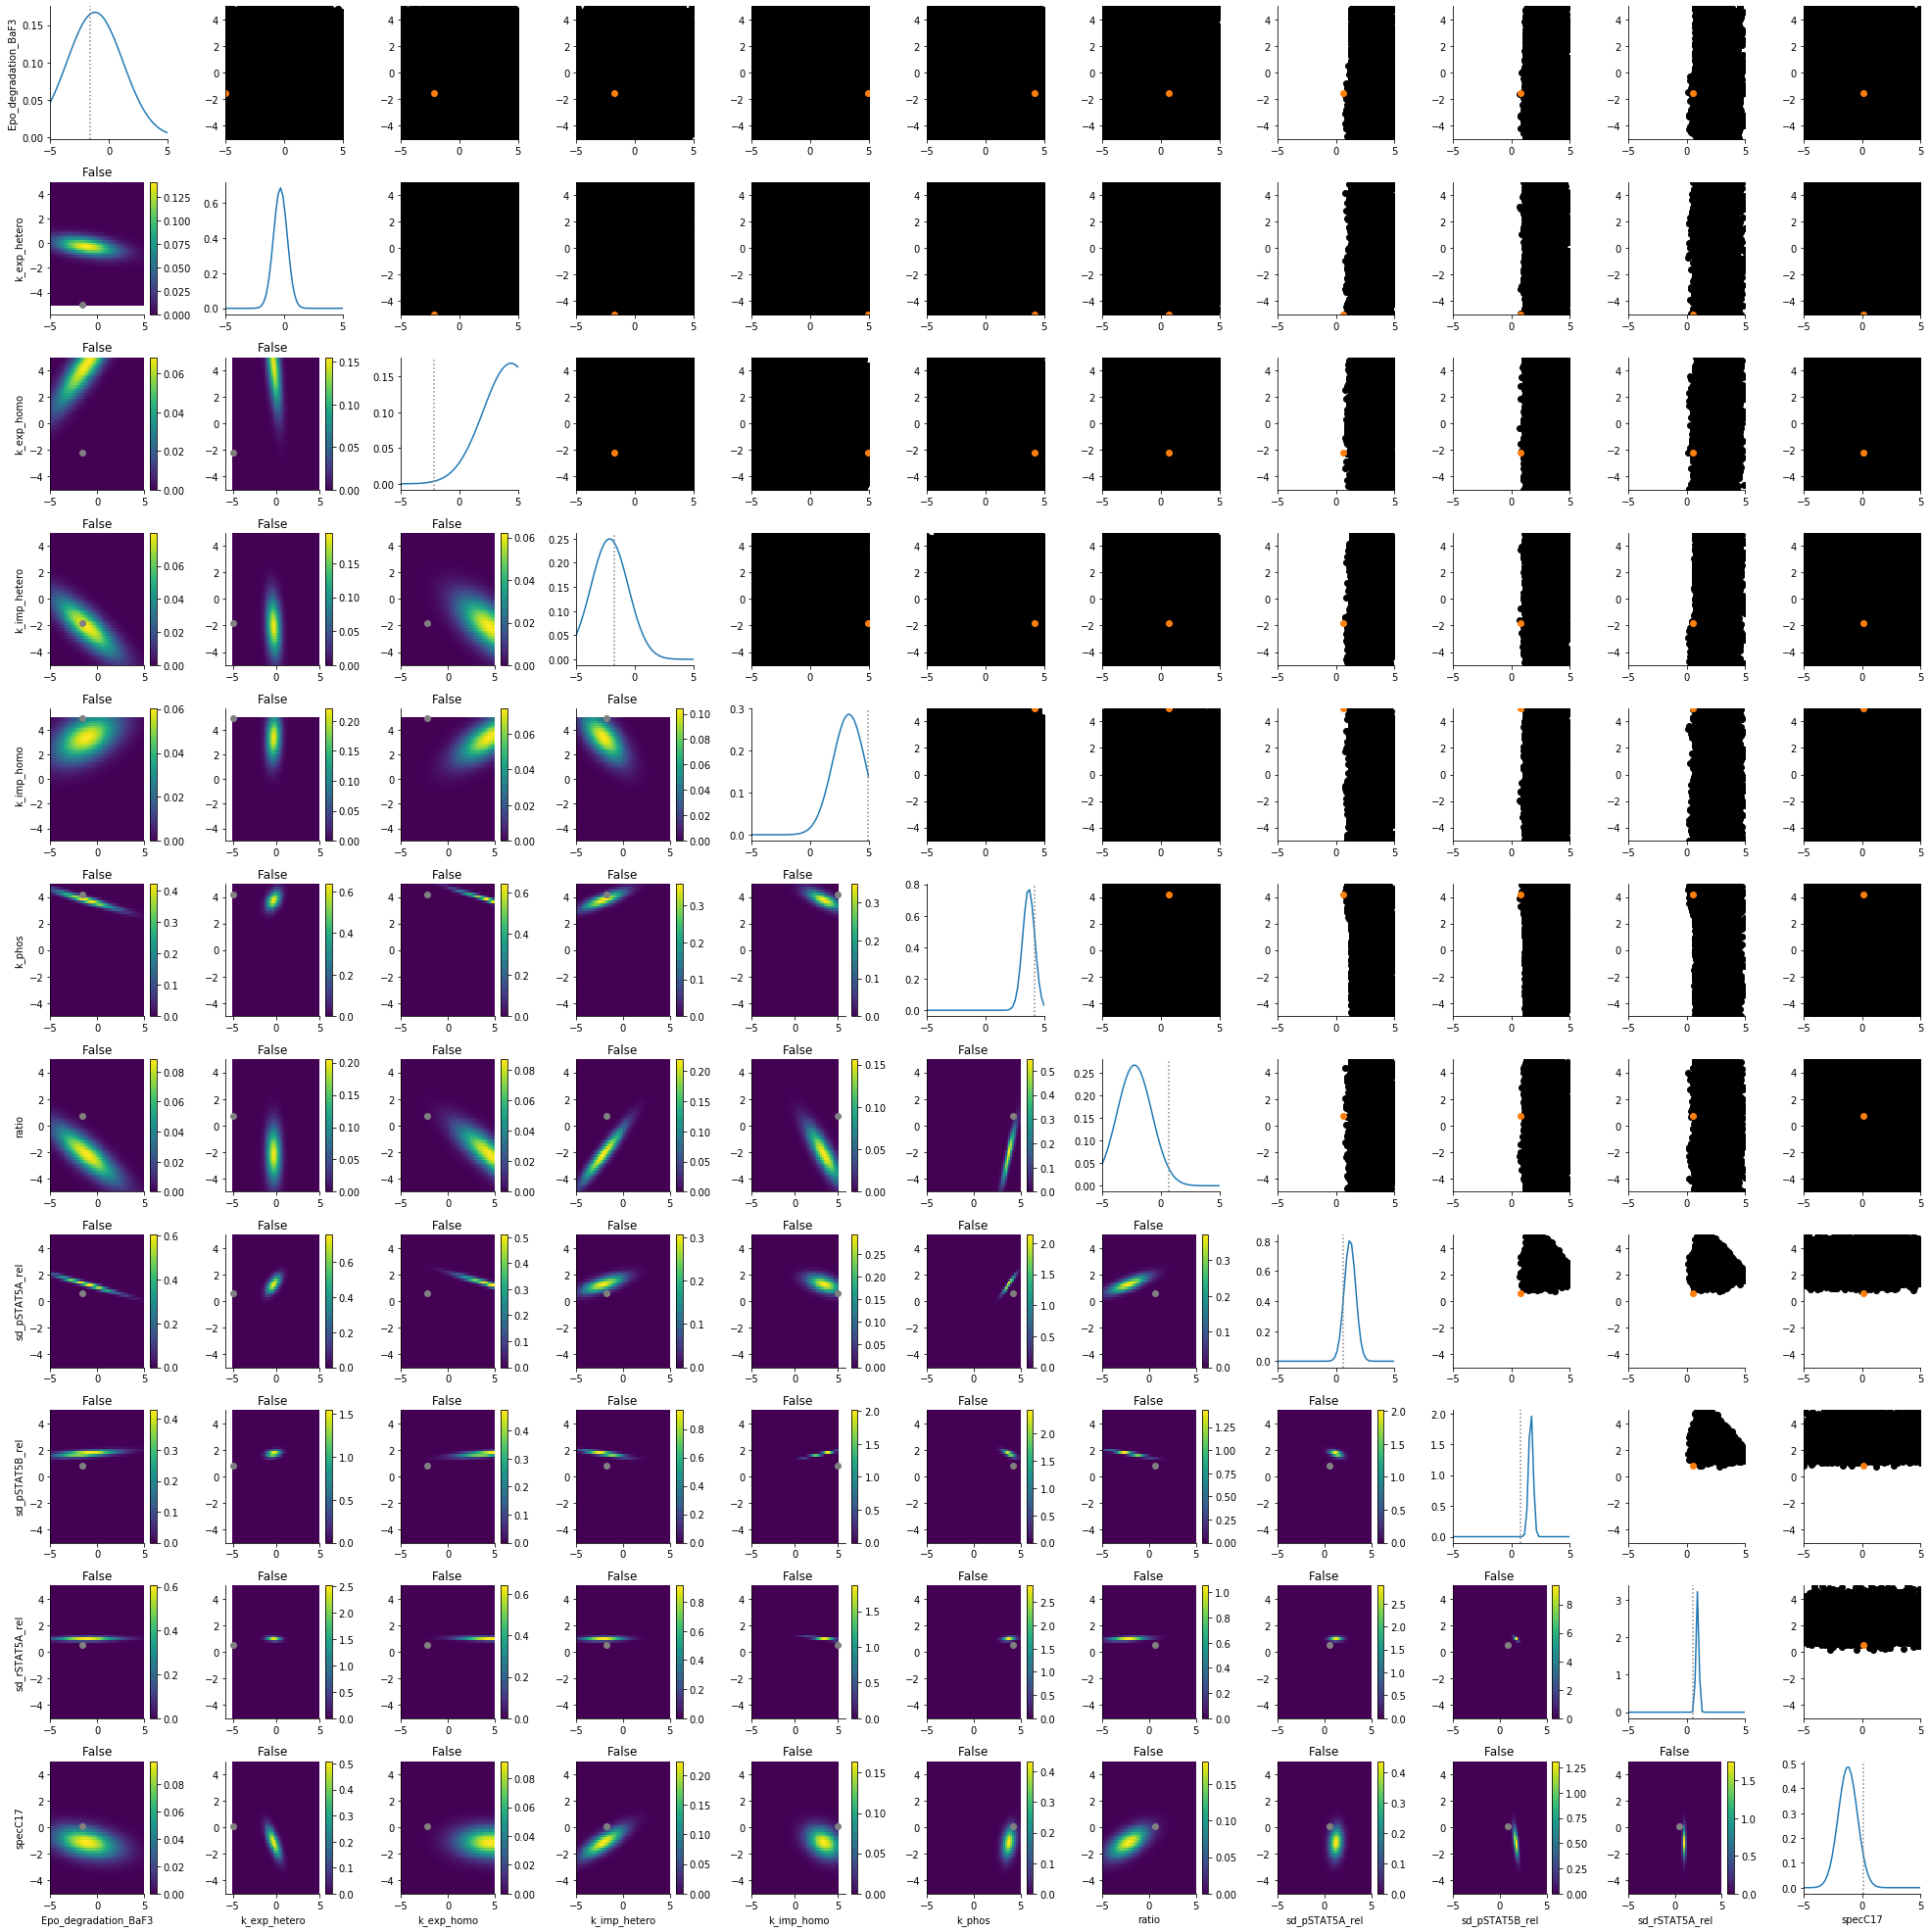

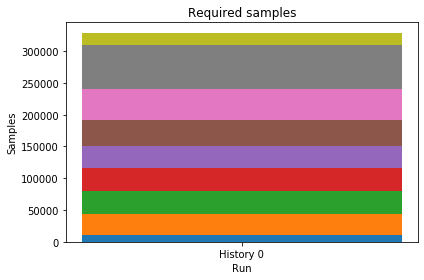

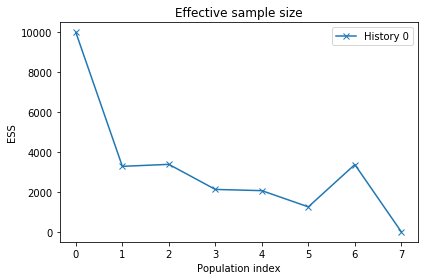

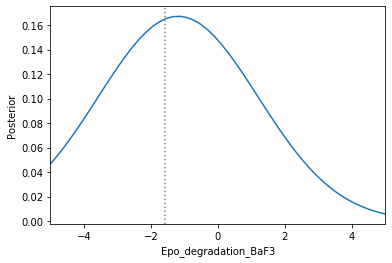

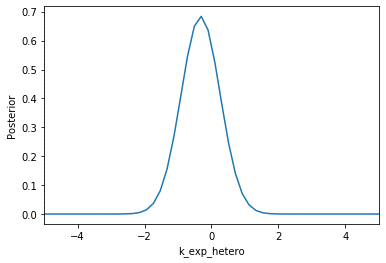

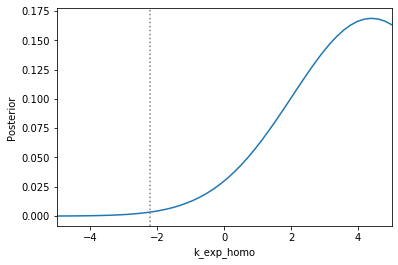

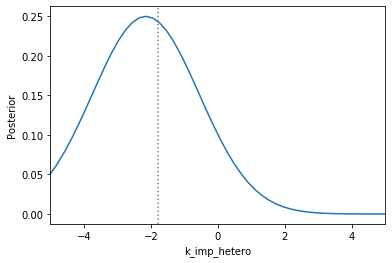

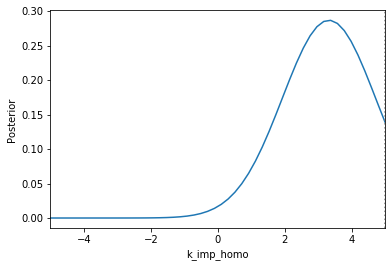

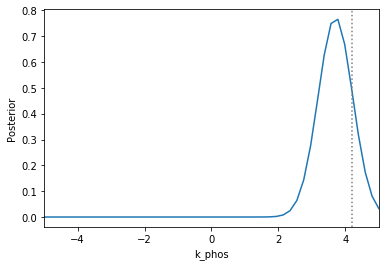

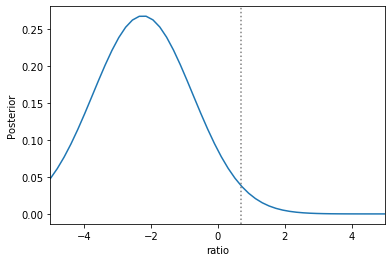

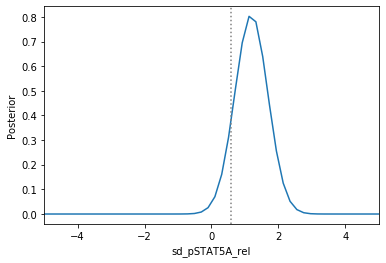

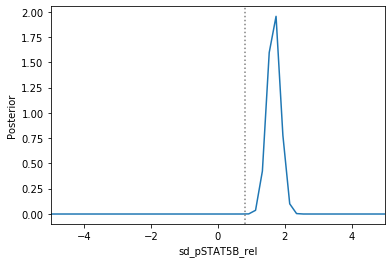

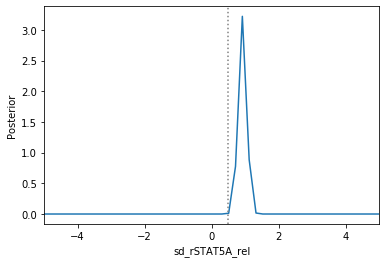

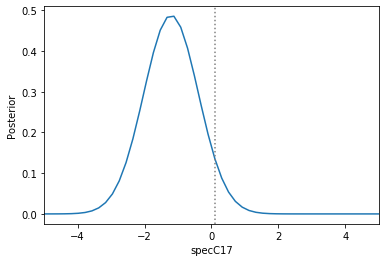

In [4]:
h = pyabc.History("sqlite:///h_boehm6.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)
pyabc.visualization.plot_sample_numbers(h)
pyabc.visualization.plot_effective_sample_sizes(h)
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])